# Information Systems Project - How Does Momentum Affect Premier League Match Results?
#### Christian Gottlieb and Michael Porter

# Motivation:

We are very interested in soccer and how momentum influences the game. Soccer often feels like a momentum-driven sport, where team chemistry, confidence, and whether a team is “clicking” can heavily shape match outcomes. It’s not uncommon to see a team with momentum outperform a technically superior side that lacks cohesion. An example of this is Leicester City’s remarkable 2016 Premier League title run. Despite having one of the least expensive rosters, which was widely viewed as less talented than some of its competitors, Leicester City defied expectations and won the league. Many observers attributed a large part of their success to sustained momentum and team cohesion. Because momentum appears to play such a significant role in match outcomes, we wanted to explore whether it can help predict the outcome of matches and whether measurable correlations exist between momentum and win probability. 

In [245]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
import numpy as np

## Scraping the Premier League match results for the 2020-21, 2021-22, 2022-23, 2023-24, and 2024-25 seasons and putting in a dataframe

In [2]:
base_url = "https://fixturedownload.com/view/json/epl-"

In [3]:
raw_matches_df = pd.DataFrame()
# looping through the websites for the premier league match results for the 20-21, 21-22, 22-23, 23-24, and 24-25 seasons
for year in range(2020,2025):
    year_url = base_url + str(year)
    year_website = requests.get(year_url)        
    soup = BeautifulSoup(year_website.content, 'html.parser')
    data = soup.find('textarea')
    data_text = data.get_text()
    curr_season_matches_df = pd.read_json(data_text)
    curr_season_matches_df['Season'] = str(year) + '-' + str(year+1) # Adding Season Column
    raw_matches_df = pd.concat([raw_matches_df, curr_season_matches_df])

C:\Users\ckgottlieb\AppData\Local\Temp\ipykernel_23800\2458789591.py:9: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  curr_season_matches_df = pd.read_json(data_text)
C:\Users\ckgottlieb\AppData\Local\Temp\ipykernel_23800\2458789591.py:9: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  curr_season_matches_df = pd.read_json(data_text)
C:\Users\ckgottlieb\AppData\Local\Temp\ipykernel_23800\2458789591.py:9: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  curr_season_matches_df = pd.read_json(data_text)
C:\Users\ckgottlieb\AppData\Local\Temp\ipykernel_23800\2458789591.py:9: FutureWarning: Passing literal json to 'read_json' i

In [4]:
raw_matches_df.head()

MatchNumber  RoundNumber               DateUtc        Location  \
0            4            1  2020-09-12 11:30:00Z  Craven Cottage   
1            3            1  2020-09-12 14:00:00Z   Selhurst Park   
2            5            1  2020-09-12 16:30:00Z         Anfield   
3            8            1  2020-09-12 19:00:00Z  London Stadium   
4            7            1  2020-09-13 13:00:00Z   The Hawthorns   

         HomeTeam     AwayTeam  Group  HomeTeamScore  AwayTeamScore     Season  
0          Fulham      Arsenal    NaN              0              3  2020-2021  
1  Crystal Palace  Southampton    NaN              1              0  2020-2021  
2       Liverpool        Leeds    NaN              4              3  2020-2021  
3        West Ham    Newcastle    NaN              0              2  2020-2021  
4       West Brom    Leicester    NaN              0              3  2020-2021

In [5]:
len(raw_matches_df)

1900

In [6]:
print(1900/5)

380.0


We see that there are 1900 total matches in the dataframe. We have the data for 5 seasons, so this is what we expect because there is 380 matches per season (38 weeks and 10 matches per week).

## Transforming the Dataframe

In [7]:
# Removing Group column 
raw_matches_df = raw_matches_df.drop('Group', axis = 1)

In [8]:
# Renaming RoundNumber and DateUtc to WeekNumber and Date
col_names = list(raw_matches_df.columns)
col_names[1:3] = ['WeekNumber','Date']
raw_matches_df.columns = col_names

In [9]:
# Nottingham Forest is listed like Nott'm Forest in one season so changing this to Nottingham Forest like it is named in the rest of the seasons
raw_matches_df['HomeTeam'] = raw_matches_df['HomeTeam'].replace({"Nott'm Forest": 'Nottingham Forest'})
raw_matches_df['AwayTeam'] = raw_matches_df['AwayTeam'].replace({"Nott'm Forest": 'Nottingham Forest'})

In [10]:
# Reordering columns
raw_matches_df = raw_matches_df.reindex(columns = ['WeekNumber','MatchNumber','HomeTeam','AwayTeam','HomeTeamScore','AwayTeamScore','Location','Date','Season'])

In [11]:
# Updated dataframe
raw_matches_df.head()

WeekNumber  MatchNumber        HomeTeam     AwayTeam  HomeTeamScore  \
0           1            4          Fulham      Arsenal              0   
1           1            3  Crystal Palace  Southampton              1   
2           1            5       Liverpool        Leeds              4   
3           1            8        West Ham    Newcastle              0   
4           1            7       West Brom    Leicester              0   

   AwayTeamScore        Location                  Date     Season  
0              3  Craven Cottage  2020-09-12 11:30:00Z  2020-2021  
1              0   Selhurst Park  2020-09-12 14:00:00Z  2020-2021  
2              3         Anfield  2020-09-12 16:30:00Z  2020-2021  
3              2  London Stadium  2020-09-12 19:00:00Z  2020-2021  
4              3   The Hawthorns  2020-09-13 13:00:00Z  2020-2021

## Creating Second Dataframe where each match is represented twice - once for each time
##### * This is to keep track of momentum data for the teams

In [12]:
# First creating a dataframe of for all the home teams
home_teams_df = pd.DataFrame(raw_matches_df)

In [13]:
# Renaming columns 
col_names = list(home_teams_df.columns)
col_names[2:6] = ['Team','Opponent','TeamGoals','OpponentGoals']
home_teams_df.columns = col_names

In [14]:
# Adding Home/Away Column (all the teams in this dataframe are home)
home_teams_df['Home/Away'] = 'Home'

In [15]:
home_teams_df.head()

WeekNumber  MatchNumber            Team     Opponent  TeamGoals  \
0           1            4          Fulham      Arsenal          0   
1           1            3  Crystal Palace  Southampton          1   
2           1            5       Liverpool        Leeds          4   
3           1            8        West Ham    Newcastle          0   
4           1            7       West Brom    Leicester          0   

   OpponentGoals        Location                  Date     Season Home/Away  
0              3  Craven Cottage  2020-09-12 11:30:00Z  2020-2021      Home  
1              0   Selhurst Park  2020-09-12 14:00:00Z  2020-2021      Home  
2              3         Anfield  2020-09-12 16:30:00Z  2020-2021      Home  
3              2  London Stadium  2020-09-12 19:00:00Z  2020-2021      Home  
4              3   The Hawthorns  2020-09-13 13:00:00Z  2020-2021      Home

In [16]:
# Next creating a dataframe for all the away teams
away_teams_df = pd.DataFrame(raw_matches_df)

In [17]:
# Renaming the columns
col_names = list(away_teams_df.columns)
col_names[2:6] = ['Opponent','Team','OpponentGoals','TeamGoals'] # Here the HomeTeam correlates with Opponent and AwayTeam corrolates with Team
away_teams_df.columns = col_names

In [18]:
away_teams_df['Home/Away'] = 'Away'

In [19]:
away_teams_df.head()

WeekNumber  MatchNumber        Opponent         Team  OpponentGoals  \
0           1            4          Fulham      Arsenal              0   
1           1            3  Crystal Palace  Southampton              1   
2           1            5       Liverpool        Leeds              4   
3           1            8        West Ham    Newcastle              0   
4           1            7       West Brom    Leicester              0   

   TeamGoals        Location                  Date     Season Home/Away  
0          3  Craven Cottage  2020-09-12 11:30:00Z  2020-2021      Away  
1          0   Selhurst Park  2020-09-12 14:00:00Z  2020-2021      Away  
2          3         Anfield  2020-09-12 16:30:00Z  2020-2021      Away  
3          2  London Stadium  2020-09-12 19:00:00Z  2020-2021      Away  
4          3   The Hawthorns  2020-09-13 13:00:00Z  2020-2021      Away

In [20]:
# Combining home_teams_df and away_teams_df to create dataframe where each match is represented twice (once for each team). We will call this dataframe df.
df = pd.concat([home_teams_df, away_teams_df])

In [21]:
df.head()

WeekNumber  MatchNumber            Team     Opponent  TeamGoals  \
0           1            4          Fulham      Arsenal          0   
1           1            3  Crystal Palace  Southampton          1   
2           1            5       Liverpool        Leeds          4   
3           1            8        West Ham    Newcastle          0   
4           1            7       West Brom    Leicester          0   

   OpponentGoals        Location                  Date     Season Home/Away  
0              3  Craven Cottage  2020-09-12 11:30:00Z  2020-2021      Home  
1              0   Selhurst Park  2020-09-12 14:00:00Z  2020-2021      Home  
2              3         Anfield  2020-09-12 16:30:00Z  2020-2021      Home  
3              2  London Stadium  2020-09-12 19:00:00Z  2020-2021      Home  
4              3   The Hawthorns  2020-09-13 13:00:00Z  2020-2021      Home

## Transforming New Dataframe (df)

In [22]:
# Creating goal differential column
df['GoalDifferential'] = df['TeamGoals'] - df['OpponentGoals']

In [23]:
# Reordering by date
df = df.sort_values(by = 'Date')

In [24]:
# Giving each row a unique ID
df['ID'] = [i for i in range(1,len(df)+1)]
df = df.set_index(df['ID'])

In [25]:
# Adding result and points column (using goal differential to calculate) (0 points for loss, 1 point for tie, 3 points for win)
def result(num):
    if num < 0:
        result = "L"
    elif num == 0:
        result = "T"
    else:
        result = "W"
    return result

def points(num):
    if num < 0:
        points = 0
    elif num == 0:
        points = 1
    else:
        points = 3
    return points
    
for col, func in {'Result':result, 'Points':points}.items():
    df[col] = df['GoalDifferential'].apply(func) 

In [26]:
# Reordering columns
df = df.reindex(columns = ['WeekNumber','MatchNumber','Team','Opponent','TeamGoals','OpponentGoals','Result','Points','GoalDifferential','Home/Away','Location','Date','Season'])

In [27]:
# Now we have this:
df.head()

WeekNumber  MatchNumber            Team        Opponent  TeamGoals  \
ID                                                                       
1            1            4          Fulham         Arsenal          0   
2            1            4         Arsenal          Fulham          3   
3            1            3     Southampton  Crystal Palace          0   
4            1            3  Crystal Palace     Southampton          1   
5            1            5       Liverpool           Leeds          4   

    OpponentGoals Result  Points  GoalDifferential Home/Away        Location  \
ID                                                                             
1               3      L       0                -3      Home  Craven Cottage   
2               0      W       3                 3      Away  Craven Cottage   
3               1      L       0                -1      Away   Selhurst Park   
4               0      W       3                 1      Home   Selhurst Park   
5               3      W       3                 1      Home         Anfield   

                    Date     Season  
ID                                   
1   2020-09-12 11:30:00Z  2020-2021  
2   2020-09-12 11:30:00Z  2020-2021  
3   2020-09-12 14:00:00Z  2020-2021  
4   2020-09-12 14:00:00Z  2020-2021  
5   2020-09-12 16:30:00Z  2020-2021

## Adding Momentum Metric Columns (Win Streak, Unbeaten Streak, Points Earned in Last 3 Matches, Points Earned in Last 5 Matches, Goal differential in last 3 matches, Goal differential in last 5 matches, loss streak (negative momentum), and Games since win (negative momentum))

In [28]:
# Creating last n points columns (how many points earned in last n matches (note: this is before the match in the current row))
def add_last_n_points_column(n):
    df['Last' + str(n) + 'Points'] = 0 # initializing lastnpoints column
    for team in list(df['Team'].unique()): # Looping through teams
        for season in list(df['Season'].unique()): # Looping through seasons
            curr_df = df[(df['Team'] == team) & (df['Season'] == season)] # Filtering to only get one team in one season at a time
            for i in range(len(curr_df)):
                lastnpoints = 0
                if i > n-1: # Checking if n game have already been played or not (i represents the row # in this case and because curr_df is only one team in one season this represents the week # as well)
                    for j in range(i-n,i):
                        lastnpoints += curr_df.iloc[j,7] # The 7th column is points
                else: # If not, add all of the points that have been earned so far
                    for j in range(0,i): 
                        lastnpoints += curr_df.iloc[j,7]
                df.loc[curr_df.index[i],'Last' + str(n) + 'Points'] = lastnpoints # Adding to df (grabbing ID to do this)
                #df.loc[list(curr_df['ID'].unique())[i],'Last' + str(n) + 'Points'] = lastnpoints # Adding to df (getting ID to do this)

# Adding last3points column and last5points column
add_last_n_points_column(3)
add_last_n_points_column(5)

In [29]:
# Just looking at Arsenal to see that this worked
df[df['Team'] == 'Arsenal'].head(10)

WeekNumber  MatchNumber     Team       Opponent  TeamGoals  \
ID                                                                
2             1            4  Arsenal         Fulham          3   
23            2           11  Arsenal       West Ham          2   
55            3           25  Arsenal      Liverpool          1   
72            4           31  Arsenal  Sheffield Utd          2   
81            5           46  Arsenal       Man City          0   
111           6           51  Arsenal      Leicester          0   
130           7           66  Arsenal        Man Utd          1   
156           8           71  Arsenal    Aston Villa          0   
169           9           84  Arsenal          Leeds          0   
191          10           91  Arsenal         Wolves          1   

     OpponentGoals Result  Points  GoalDifferential Home/Away  \
ID                                                              
2                0      W       3                 3      Away   
23               1      W       3                 1      Home   
55               3      L       0                -2      Away   
72               1      W       3                 1      Home   
81               1      L       0                -1      Away   
111              1      L       0                -1      Home   
130              0      W       3                 1      Away   
156              3      L       0                -3      Home   
169              0      T       1                 0      Away   
191              2      L       0                -1      Home   

             Location                  Date     Season  Last3Points  \
ID                                                                    
2      Craven Cottage  2020-09-12 11:30:00Z  2020-2021            0   
23   Emirates Stadium  2020-09-19 19:00:00Z  2020-2021            3   
55            Anfield  2020-09-28 19:00:00Z  2020-2021            6   
72   Emirates Stadium  2020-10-04 13:00:00Z  2020-2021            6   
81     Etihad Stadium  2020-10-17 16:30:00Z  2020-2021            6   
111  Emirates Stadium  2020-10-25 19:15:00Z  2020-2021            3   
130      Old Trafford  2020-11-01 16:30:00Z  2020-2021            3   
156  Emirates Stadium  2020-11-08 19:15:00Z  2020-2021            3   
169       Elland Road  2020-11-22 16:30:00Z  2020-2021            3   
191  Emirates Stadium  2020-11-29 19:15:00Z  2020-2021            4   

     Last5Points  
ID                
2              0  
23             3  
55             6  
72             6  
81             9  
111            9  
130            6  
156            6  
169            6  
191            4

In [30]:
# Creating last n goal differential columns (the goal differential over the last n matches (note: this is before the match in the current row))
# This function is very similiar to add_last_n_points_column
def add_last_n_gd_column(n):
    df['Last' + str(n) + 'GD'] = 0 # initializing lastnpoints column
    for team in list(df['Team'].unique()): # Looping through teams
        for season in list(df['Season'].unique()): # Looping through seasons
            curr_df = df[(df['Team'] == team) & (df['Season'] == season)] # Filtering to only get one team in one season at a time
            for i in range(len(curr_df)):
                lastnGD = 0
                if i > n-1: # Checking if n game have already been played or not (i represents the row # in this case and because curr_df is only one team in one season this represents the week # as well)
                    for j in range(i-n,i):
                        lastnGD += curr_df.iloc[j,8] # The 8th column is points
                else: # If not, add all of the points that have been earned so far
                    for j in range(0,i): 
                        lastnGD += curr_df.iloc[j,8]
                df.loc[curr_df.index[i],'Last' + str(n) + 'GD'] = lastnGD # Adding to df

# Adding last3GD column and last5GD column
add_last_n_gd_column(3)
add_last_n_gd_column(5)

In [31]:
df.head()

WeekNumber  MatchNumber            Team        Opponent  TeamGoals  \
ID                                                                       
1            1            4          Fulham         Arsenal          0   
2            1            4         Arsenal          Fulham          3   
3            1            3     Southampton  Crystal Palace          0   
4            1            3  Crystal Palace     Southampton          1   
5            1            5       Liverpool           Leeds          4   

    OpponentGoals Result  Points  GoalDifferential Home/Away        Location  \
ID                                                                             
1               3      L       0                -3      Home  Craven Cottage   
2               0      W       3                 3      Away  Craven Cottage   
3               1      L       0                -1      Away   Selhurst Park   
4               0      W       3                 1      Home   Selhurst Park   
5               3      W       3                 1      Home         Anfield   

                    Date     Season  Last3Points  Last5Points  Last3GD  \
ID                                                                       
1   2020-09-12 11:30:00Z  2020-2021            0            0        0   
2   2020-09-12 11:30:00Z  2020-2021            0            0        0   
3   2020-09-12 14:00:00Z  2020-2021            0            0        0   
4   2020-09-12 14:00:00Z  2020-2021            0            0        0   
5   2020-09-12 16:30:00Z  2020-2021            0            0        0   

    Last5GD  
ID           
1         0  
2         0  
3         0  
4         0  
5         0

In [32]:
# Creating streak columns (These restarts at the beggining of the season - ie. if a team doesn't win the first 5 games, the loss streak before 
# will be 5 even if they lost the last game the year before)
def add_streak_columns(streaks_dict):
    for key in streaks_dict.keys():
        df[key] = 0 # initializing streak columns
    for team in list(df['Team'].unique()): # Looping through teams
        for season in list(df['Season'].unique()): # Looping through seasons
            curr_df = df[(df['Team'] == team) & (df['Season'] == season)] # Filtering to only get one team in one season at a time
            for key, value in streaks_dict.items():
                curr_streak = 0
                for i in range(len(curr_df)):
                    if i > 0: # Making sure it's not the first game
                        if curr_df.iloc[i-1,6] in value: # value is a list
                            curr_streak += 1
                        else:
                            curr_streak = 0
                    df.loc[curr_df.index[i],key] = curr_streak # Adding to df


# streaks dictionary for streak_column function: the keys are the columns names, the values are lists containing the criteria for the streak
streaks_dict = {'WinStreakBefore': ['W'], 'UnbeatenStreakBefore': ['W','T'], 'LossStreakBefore': ['L'], 'GamesSinceWin': ['L','T']} 

add_streak_columns(streaks_dict)


In [33]:
df.head()

WeekNumber  MatchNumber            Team        Opponent  TeamGoals  \
ID                                                                       
1            1            4          Fulham         Arsenal          0   
2            1            4         Arsenal          Fulham          3   
3            1            3     Southampton  Crystal Palace          0   
4            1            3  Crystal Palace     Southampton          1   
5            1            5       Liverpool           Leeds          4   

    OpponentGoals Result  Points  GoalDifferential Home/Away  ...  \
ID                                                            ...   
1               3      L       0                -3      Home  ...   
2               0      W       3                 3      Away  ...   
3               1      L       0                -1      Away  ...   
4               0      W       3                 1      Home  ...   
5               3      W       3                 1      Home  ...   

                    Date     Season Last3Points  Last5Points  Last3GD  \
ID                                                                      
1   2020-09-12 11:30:00Z  2020-2021           0            0        0   
2   2020-09-12 11:30:00Z  2020-2021           0            0        0   
3   2020-09-12 14:00:00Z  2020-2021           0            0        0   
4   2020-09-12 14:00:00Z  2020-2021           0            0        0   
5   2020-09-12 16:30:00Z  2020-2021           0            0        0   

    Last5GD  WinStreakBefore  UnbeatenStreakBefore  LossStreakBefore  \
ID                                                                     
1         0                0                     0                 0   
2         0                0                     0                 0   
3         0                0                     0                 0   
4         0                0                     0                 0   
5         0                0                     0                 0   

    GamesSinceWin  
ID                 
1               0  
2               0  
3               0  
4               0  
5               0  

[5 rows x 21 columns]

In [34]:
# Checking Chelsea in 2024-2025 to make sure everything worked
df[(df['Team'] == 'Chelsea') & (df['Season'] == '2024-2025')].head(10)

WeekNumber  MatchNumber     Team           Opponent  TeamGoals  \
ID                                                                     
3057           1            9  Chelsea           Man City          0   
3078           2           20  Chelsea             Wolves          6   
3097           3           23  Chelsea     Crystal Palace          1   
3115           4           32  Chelsea        Bournemouth          1   
3121           5           50  Chelsea           West Ham          3   
3152           6           54  Chelsea           Brighton          4   
3175           7           65  Chelsea  Nottingham Forest          1   
3198           8           74  Chelsea          Liverpool          1   
3218           9           85  Chelsea          Newcastle          2   
3237          10           95  Chelsea            Man Utd          1   

      OpponentGoals Result  Points  GoalDifferential Home/Away  ...  \
ID                                                              ...   
3057              2      L       0                -2      Home  ...   
3078              2      W       3                 4      Away  ...   
3097              1      T       1                 0      Home  ...   
3115              0      W       3                 1      Away  ...   
3121              0      W       3                 3      Away  ...   
3152              2      W       3                 2      Home  ...   
3175              1      T       1                 0      Home  ...   
3198              2      L       0                -1      Away  ...   
3218              1      W       3                 1      Home  ...   
3237              1      T       1                 0      Away  ...   

                      Date     Season Last3Points  Last5Points  Last3GD  \
ID                                                                        
3057  2024-08-18 15:30:00Z  2024-2025           0            0        0   
3078  2024-08-25 13:00:00Z  2024-2025           0            0       -2   
3097  2024-09-01 12:30:00Z  2024-2025           3            3        2   
3115  2024-09-14 19:00:00Z  2024-2025           4            4        2   
3121  2024-09-21 11:30:00Z  2024-2025           7            7        5   
3152  2024-09-28 14:00:00Z  2024-2025           7           10        4   
3175  2024-10-06 13:00:00Z  2024-2025           9           13        6   
3198  2024-10-20 15:30:00Z  2024-2025           7           11        5   
3218  2024-10-27 14:00:00Z  2024-2025           4           10        1   
3237  2024-11-03 16:30:00Z  2024-2025           4           10        0   

      Last5GD  WinStreakBefore  UnbeatenStreakBefore  LossStreakBefore  \
ID                                                                       
3057        0                0                     0                 0   
3078       -2                0                     0                 1   
3097        2                1                     1                 0   
3115        2                0                     2                 0   
3121        3                1                     3                 0   
3152        6                2                     4                 0   
3175       10                3                     5                 0   
3198        6                0                     6                 0   
3218        5                0                     0                 1   
3237        5                1                     1                 0   

      GamesSinceWin  
ID                   
3057              0  
3078              1  
3097              0  
3115              1  
3121              0  
3152              0  
3175              0  
3198              1  
3218              2  
3237              0  

[10 rows x 21 columns]

## Creating Additonal Dataframes for analysis and visualizations

In [35]:
# function that creates df grouped by momentum metrics and shows win %, tie %, and loss % for each group
def create_result_df(metric):
    groups = df.groupby(metric)
    group_counts = groups.size()
    result_by_metric = group_counts.to_frame() # Transforming series of win streak counts to dataframe
    result_by_metric.columns = ['SampleSize'] #Naming column
    result_by_metric['WinPercentage'] = (df.groupby(metric)['Result'].apply(lambda x: (x == 'W').mean())) # Calculating WinPercentage by Metric
    result_by_metric['TiePercentage'] = (df.groupby(metric)['Result'].apply(lambda x: (x == 'T').mean())) # Calculating TiePercentage by Metric
    result_by_metric['LossPercentage'] = (df.groupby(metric)['Result'].apply(lambda x: (x == 'L').mean())) # Calculating LossPercentage by Metric

    return result_by_metric

result_by_winstreak = create_result_df('WinStreakBefore')
result_by_unbeatenstreak = create_result_df('UnbeatenStreakBefore')
result_by_last3points = create_result_df('Last3Points')
result_by_last5points = create_result_df('Last5Points')
result_by_last3GD = create_result_df('Last3GD')
result_by_last5GD = create_result_df('Last5GD')
result_by_lossstreak = create_result_df('LossStreakBefore')
result_by_gamessincewin = create_result_df('GamesSinceWin')                      

We know have 8 additional dataframes that show results by different momentum metrics. We will use these to create visualizations and do analysis.

In [36]:
# Examples of one of these dfs
result_by_winstreak

SampleSize  WinPercentage  TiePercentage  LossPercentage
WinStreakBefore                                                          
0                      2378       0.357864       0.224138        0.417998
1                       827       0.390568       0.235792        0.373640
2                       315       0.463492       0.225397        0.311111
3                       140       0.478571       0.264286        0.257143
4                        65       0.492308       0.215385        0.292308
5                        29       0.551724       0.206897        0.241379
6                        15       0.533333       0.266667        0.200000
7                         8       0.750000       0.250000        0.000000
8                         6       0.833333       0.166667        0.000000
9                         4       1.000000       0.000000        0.000000
10                        4       0.750000       0.250000        0.000000
11                        3       1.000000       0.000000        0.000000
12                        3       0.333333       0.666667        0.000000
13                        1       1.000000       0.000000        0.000000
14                        1       1.000000       0.000000        0.000000
15                        1       0.000000       0.000000        1.000000

In [258]:
result_by_last3points

SampleSize  WinPercentage  TiePercentage  LossPercentage  \
Last3Points                                                             
0                   417       0.314149       0.208633        0.477218   
1                   443       0.306998       0.216704        0.476298   
2                   223       0.327354       0.282511        0.390135   
3                   656       0.342988       0.228659        0.428354   
4                   650       0.376923       0.230769        0.392308   
5                   216       0.458333       0.212963        0.328704   
6                   502       0.420319       0.225100        0.354582   
7                   413       0.484262       0.227603        0.288136   
9                   280       0.525000       0.239286        0.235714   

             PointsEarned  
Last3Points                
0                1.151079  
1                1.137698  
2                1.264574  
3                1.257622  
4                1.361538  
5                1.587963  
6                1.486056  
7                1.680387  
9                1.814286

# Questions:

# Q1: Does Win Streak Correlate with the Outcome of the next match?

### a) Looking at Win Percentage by Win Streak

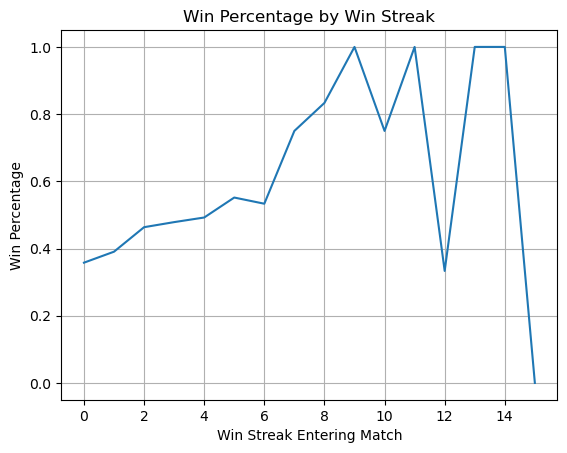

In [37]:
plt.plot(result_by_winstreak.index, result_by_winstreak['WinPercentage'])
plt.xlabel("Win Streak Entering Match")
plt.ylabel("Win Percentage")
plt.title("Win Percentage by Win Streak")
plt.grid(True)
plt.show()

We see a correlation, when winstreak is between 0 and 9, but then the win percentage is all over the place when the sample size is low.

#### What if we got rid of data that didn't have a big enough sample size?

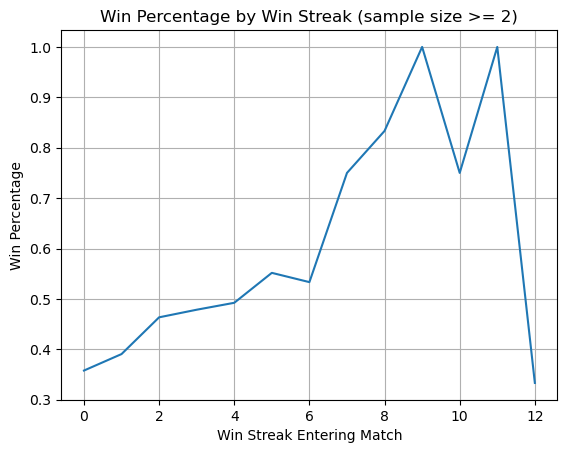

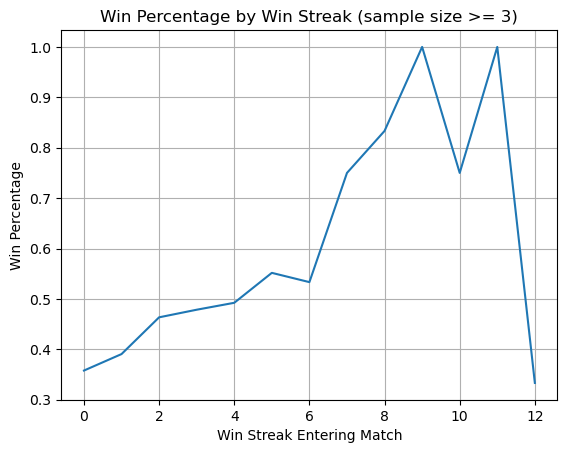

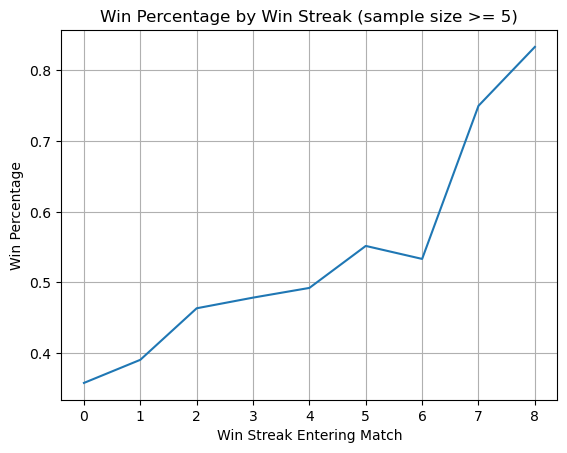

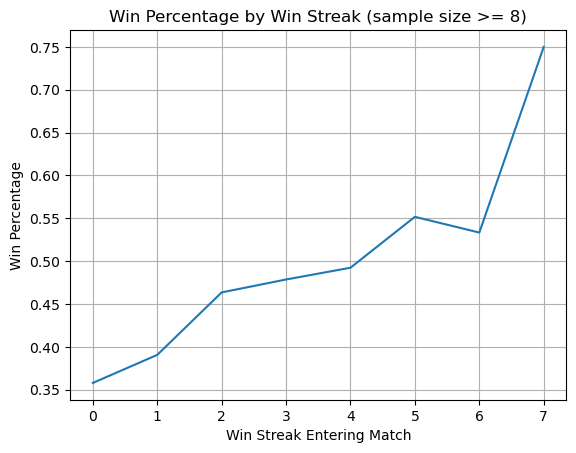

In [264]:
sample_size_mins = [2,3,5,8] # trying these minimum sample sizes
for num in sample_size_mins: 
    mask = result_by_winstreak['SampleSize'] >= num # requiring minimum samplesize
    reduced_data = result_by_winstreak[mask]
    plt.plot(reduced_data.index, reduced_data['WinPercentage'])
    plt.xlabel("Win Streak Entering Match")
    plt.ylabel("Win Percentage")
    plt.title("Win Percentage by Win Streak (sample size >= " + str(num) + ")")
    plt.grid(True)
    plt.show()

It is evident that there is a correlation between win percentage and win streak, when we required a minimum sample size. We get the best results when the minimum sample size is 5.

#### Using a minimum sample size of 5, lets add a linear regression line (using seaborn)

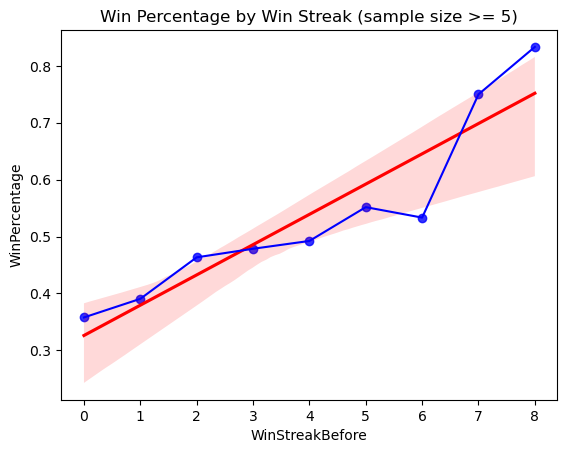

In [157]:
mask = result_by_winstreak['SampleSize'] >= 5
reduced_data = result_by_winstreak[mask]
sns.regplot(x=reduced_data.index, y=reduced_data['WinPercentage'], color='blue', line_kws={"color": "red"})
plt.plot(reduced_data.index, reduced_data['WinPercentage'], color='blue')
plt.title("Win Percentage by Win Streak (sample size >= 5)")
plt.show()

We can see a clear correlation bwteen win streak and win percentage

In [158]:
# Calculating the slope, intercept, and r-value of the regression line
x = reduced_data.index.values
y = reduced_data['WinPercentage'].values

reg_line = linregress(x, y)

print('Slope:', reg_line.slope)
print('R-value:', reg_line.rvalue)

Slope: 0.05321681034153181
R-value: 0.9270352434119623


This tells us that we can expect the win % to increase by about 5.3 % for each additional win in a team's win streak. There is a very strong correlation between WinStreakBefore and WinPercentage (an r-value of 0.927!)

### b) Let's look at all results based on winstreak

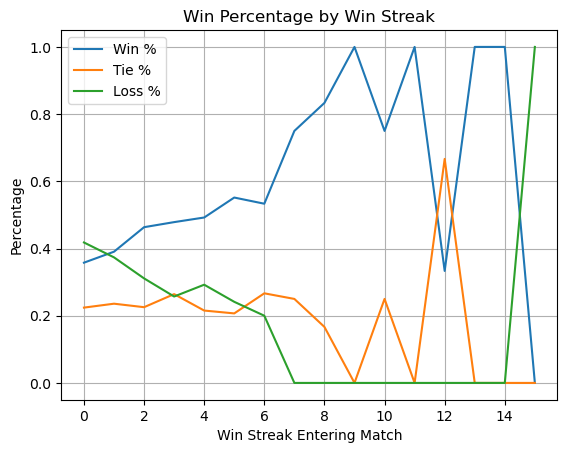

In [41]:
plt.plot(result_by_winstreak.index, result_by_winstreak['WinPercentage'], label = 'Win %')
plt.plot(result_by_winstreak.index, result_by_winstreak['TiePercentage'], label = 'Tie %')
plt.plot(result_by_winstreak.index, result_by_winstreak['LossPercentage'], label = 'Loss %')
plt.xlabel("Win Streak Entering Match")
plt.ylabel("Percentage")
plt.title("Win Percentage by Win Streak")
plt.grid(True)
plt.legend()
plt.show()

#### Let's get ride of data where the sample size is < 5

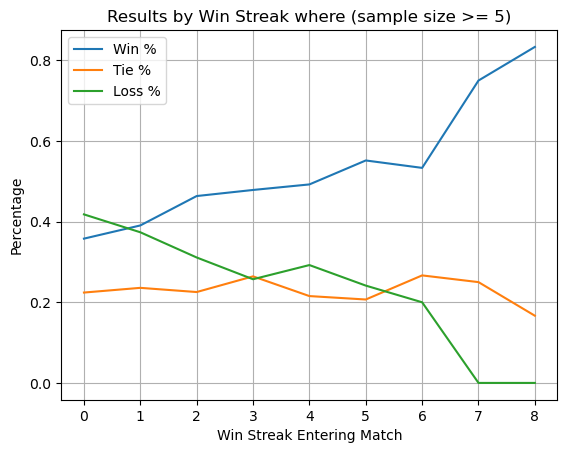

In [42]:
mask = result_by_winstreak['SampleSize'] >= 5
reduced_data = result_by_winstreak[mask]
plt.plot(reduced_data.index, reduced_data['WinPercentage'], label = 'Win %')
plt.plot(reduced_data.index, reduced_data['TiePercentage'], label = 'Tie %')
plt.plot(reduced_data.index, reduced_data['LossPercentage'], label = 'Loss %')
plt.xlabel("Win Streak Entering Match")
plt.ylabel("Percentage")
plt.title("Results by Win Streak where (sample size >= 5)")
plt.grid(True)
plt.legend()
plt.show()

We can see that the win % increases as the win streak goes up, and the loss % decreases as the win streak goes up. The tie % doesn't seem to be affected.

#### Adding Linear Regression Lines

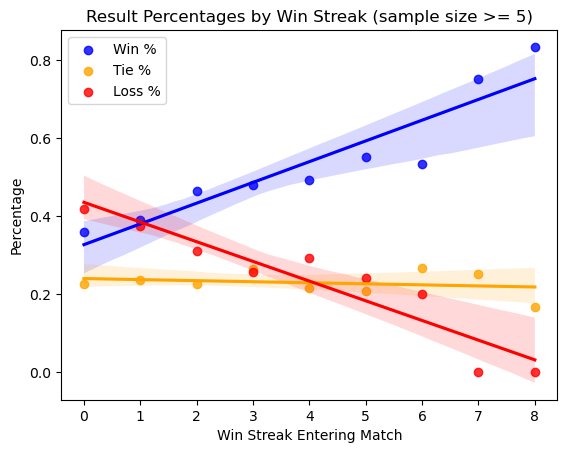

In [155]:
mask = result_by_winstreak['SampleSize'] >= 5
reduced_data = result_by_winstreak[mask]
sns.regplot(x=reduced_data.index, y=reduced_data['WinPercentage'], color='blue', line_kws={'color': 'blue'}, label = 'Win %')
sns.regplot(x=reduced_data.index, y=reduced_data['TiePercentage'], color='orange', line_kws={'color': 'orange'}, label = 'Tie %')
sns.regplot(x=reduced_data.index, y=reduced_data['LossPercentage'], color='red', line_kws={'color': 'red'}, label = 'Loss %')
plt.xlabel("Win Streak Entering Match")
plt.ylabel("Percentage")
plt.title("Result Percentages by Win Streak (sample size >= 5)")
plt.legend()
plt.show()

In [156]:
# Calculating the slopem intercept, and r-value of the linear regression lines
x = reduced_data.index.values
results = []
reg_data = {'Win': reduced_data['WinPercentage'].values, 'Tie': reduced_data['TiePercentage'].values, 'Loss': reduced_data['LossPercentage'].values}

for name, y in reg_data.items():
    reg_line = linregress(x, y)
    results.append({'Result': name,'Slope': reg_line.slope,'R-value': reg_line.rvalue})

results_df = pd.DataFrame(results)
results_df

Result     Slope   R-value
0    Win  0.053217  0.927035
1    Tie -0.002702 -0.237833
2   Loss -0.050515 -0.938197

We see a strong positive correlation between win % and win streak, a strong negative correlation between loss % and win streak, and a week negative correlation between tie % and win streak.

# Q2: Does Unbeaten Streak Correlate with the Outcome of the next match?

### a) Looking at just unbeaten percentage by unbeatenstreak
- Unbeaten means either tieing or winning (ie not losing)

In [45]:
# to do this we are going to add unbeaten percentage to result_by_unbeatenpercentage_df
result_by_unbeatenstreak['UnbeatenPercentage'] = (df.groupby('UnbeatenStreakBefore')['Result'].apply(lambda x: (x != 'L').mean())) # Unbeaten is just if the team doesn't lose

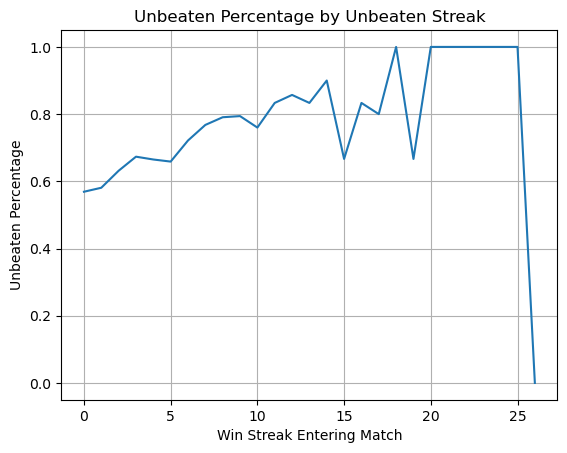

In [46]:
plt.plot(result_by_unbeatenstreak.index, result_by_unbeatenstreak['UnbeatenPercentage'])
plt.xlabel("Win Streak Entering Match")
plt.ylabel("Unbeaten Percentage")
plt.title("Unbeaten Percentage by Unbeaten Streak")
plt.grid(True)
plt.show()

#### Let's require a sample size >= 5 like we did in Question 1

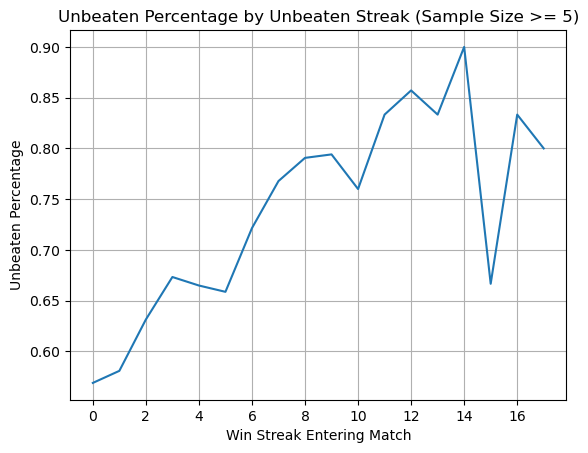

In [47]:
mask = result_by_unbeatenstreak['SampleSize'] >= 5
reduced_data = result_by_unbeatenstreak[mask]
plt.plot(reduced_data.index, reduced_data['UnbeatenPercentage'])
plt.xlabel("Win Streak Entering Match")
plt.ylabel("Unbeaten Percentage")
plt.title("Unbeaten Percentage by Unbeaten Streak (Sample Size >= 5)")
plt.grid(True)
plt.xticks(range(0, 17, 2)) # Changing What x tick marks count by
plt.show()

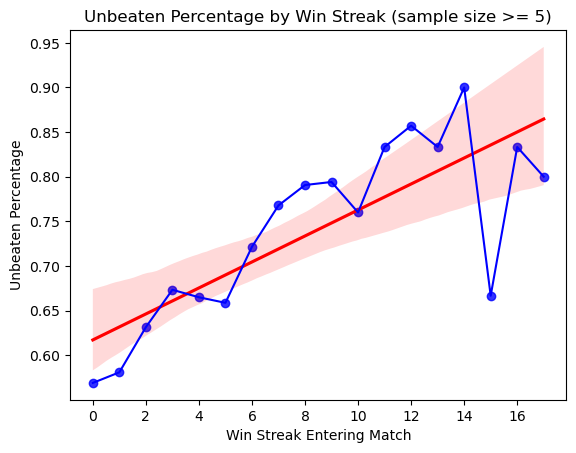

In [152]:
# Linear Regression line plot
mask = result_by_unbeatenstreak['SampleSize'] >= 5
reduced_data = result_by_unbeatenstreak[mask]
sns.regplot(x=reduced_data.index, y=reduced_data['UnbeatenPercentage'], color='blue', line_kws={"color": "red"})
plt.plot(reduced_data.index, reduced_data['UnbeatenPercentage'], color='blue')
plt.xlabel("Win Streak Entering Match")
plt.ylabel("Unbeaten Percentage")
plt.title("Unbeaten Percentage by Win Streak (sample size >= 5)")
plt.xticks(range(0, 17, 2))
plt.show()

In [154]:
# Calculating the slope and r-value of the linear regression line
x = reduced_data.index.values
y = reduced_data['UnbeatenPercentage'].values

reg_line = linregress(x, y)

print('Slope:', reg_line.slope)
print('R-value:', reg_line.rvalue)

Slope: 0.014559607145613331
R-value: 0.7902481110590761


We see a positve correlation netween unbeaten streak and unbeaten percentage. Although, this is not as strong as the correlation between win streak and win percentage.

### b) Let's look at all results based on unbeaten streak

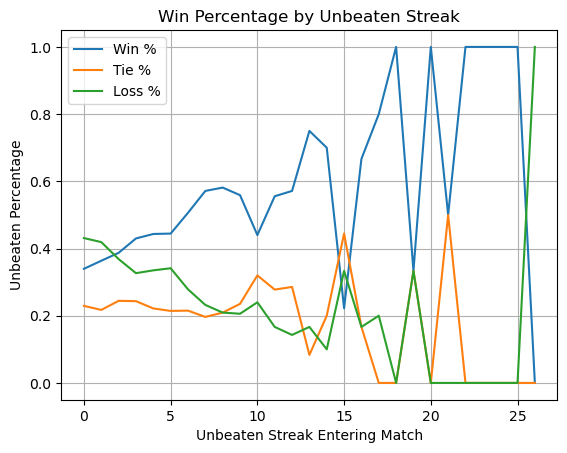

In [50]:
plt.plot(result_by_unbeatenstreak.index, result_by_unbeatenstreak['WinPercentage'], label = 'Win %')
plt.plot(result_by_unbeatenstreak.index, result_by_unbeatenstreak['TiePercentage'], label = 'Tie %')
plt.plot(result_by_unbeatenstreak.index, result_by_unbeatenstreak['LossPercentage'], label = 'Loss %')
plt.xlabel("Unbeaten Streak Entering Match")
plt.ylabel("Unbeaten Percentage")
plt.title("Win Percentage by Unbeaten Streak")
plt.grid(True)
plt.legend()
plt.show()

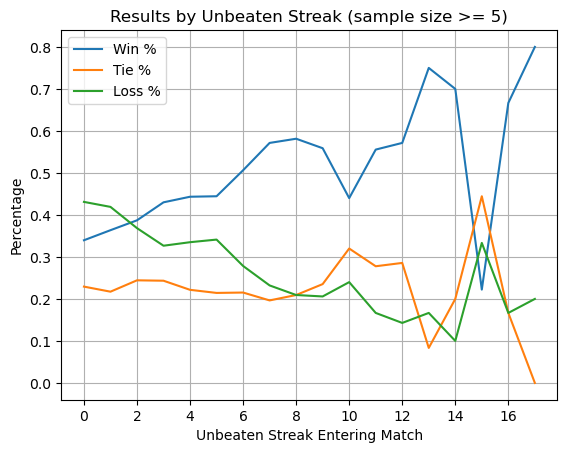

In [51]:
# Requiring minimum sample size of 5
mask = result_by_unbeatenstreak['SampleSize'] >= 5
reduced_data = result_by_unbeatenstreak[mask]
plt.plot(reduced_data.index, reduced_data['WinPercentage'], label = 'Win %')
plt.plot(reduced_data.index, reduced_data['TiePercentage'], label = 'Tie %')
plt.plot(reduced_data.index, reduced_data['LossPercentage'], label = 'Loss %')
plt.xlabel("Unbeaten Streak Entering Match")
plt.ylabel("Percentage")
plt.title("Results by Unbeaten Streak (sample size >= 5)")
plt.grid(True)
plt.legend()
plt.xticks(range(0, 18, 2))
plt.show()

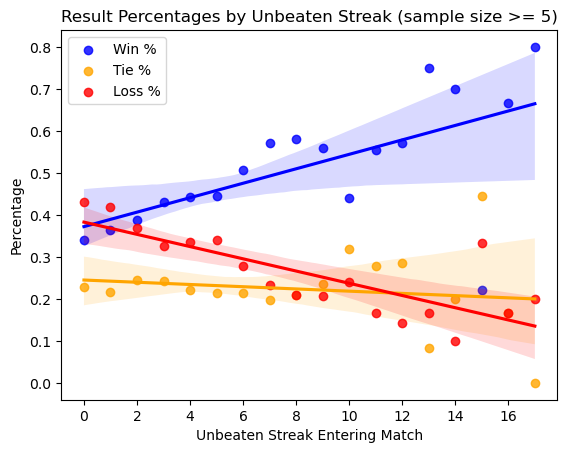

In [265]:
# linear regression line plots
mask = result_by_unbeatenstreak['SampleSize'] >= 5
reduced_data = result_by_unbeatenstreak[mask]
sns.regplot(x=reduced_data.index, y=reduced_data['WinPercentage'], color='blue', line_kws={'color': 'blue'}, label = 'Win %')
sns.regplot(x=reduced_data.index, y=reduced_data['TiePercentage'], color='orange', line_kws={'color': 'orange'}, label = 'Tie %')
sns.regplot(x=reduced_data.index, y=reduced_data['LossPercentage'], color='red', line_kws={'color': 'red'}, label = 'Loss %')
plt.xlabel("Unbeaten Streak Entering Match")
plt.ylabel("Percentage")
plt.title("Result Percentages by Unbeaten Streak (sample size >= 5)")
plt.xticks(range(0, 18, 2))
plt.legend()
plt.show()

In [151]:
# Calculating the slope, intercept, and r-value of the linear regression lines and putting in df to display
x = reduced_data.index.values
results = []
reg_data = {'Win': reduced_data['WinPercentage'].values, 'Tie': reduced_data['TiePercentage'].values, 'Loss': reduced_data['LossPercentage'].values}

for name, y in reg_data.items():
    reg_line = linregress(x, y)
    results.append({'Result': name,'Slope': reg_line.slope, 'R-value': reg_line.rvalue})

results_df = pd.DataFrame(results)
results_df

Result     Slope   R-value
0    Win  0.017209  0.609233
1    Tie -0.002649 -0.155587
2   Loss -0.014560 -0.790248

We see a relatively strong negative correlation between unbeaten streak and loss %, but unbeaten streak and win % and unbeaten streak and tie % have week correlations.

# Q3: Does Points earned in the last n matches correlate with points earned in the next match?

Using n = 3 and n = 5

In [56]:
# Adding Points Earned column (to show this in addition to match percentages)
result_by_last3points['PointsEarned'] = (df.groupby('Last3Points')['Points']).mean()
result_by_last5points['PointsEarned'] = (df.groupby('Last5Points')['Points']).mean()

### a) Does Points earned in the last 3 matches predict points earned in the next match?

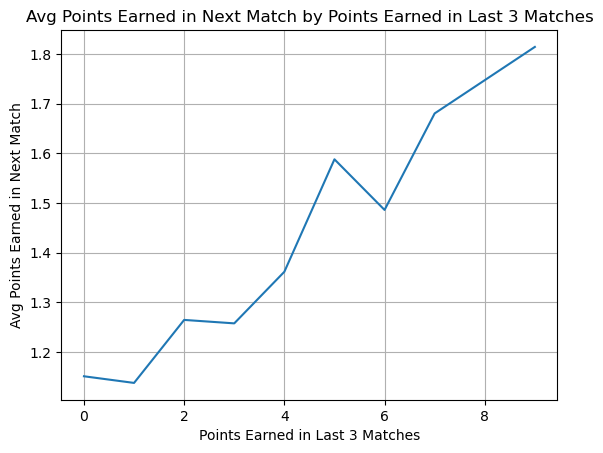

In [57]:
# we don't need to apply any sample size filters because all of the groups have a sample size much larger than 5
plt.plot(result_by_last3points.index, result_by_last3points['PointsEarned'])
plt.xlabel("Points Earned in Last 3 Matches")
plt.ylabel("Avg Points Earned in Next Match")
plt.title("Avg Points Earned in Next Match by Points Earned in Last 3 Matches")
plt.grid(True)
plt.show()

We can see a positive correlation between points earned in last 3 matches and average points earned in next match. 

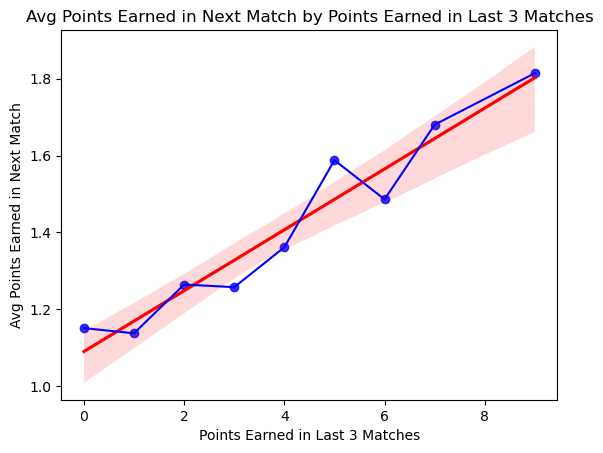

In [146]:
# we don't need to apply any sample size filters because all of the groups have a sample size much larger than 5
sns.regplot(x=result_by_last3points.index, y=result_by_last3points['PointsEarned'], color='blue', line_kws={"color": "red"})
plt.plot(result_by_last3points.index, result_by_last3points['PointsEarned'], color='blue')
plt.title("Avg Points Earned in Next Match by Points Earned in Last 3 Matches")
plt.xlabel("Points Earned in Last 3 Matches")
plt.ylabel("Avg Points Earned in Next Match")
plt.show()

In [147]:
# Calculating the slope and r-value of the linear regression line
x = result_by_last3points.index.values
y = result_by_last3points['PointsEarned'].values

reg_line = linregress(x, y)

print('Slope:', reg_line.slope)
print('R-value:', reg_line.rvalue)

Slope: 0.07915350587701134
R-value: 0.9669409790531964


We see a very strong positive correlation between points earned in last 3 matches and average points earned in next match.

### b) Does Points earned in the last 5 matches correlate points earned in the next match?

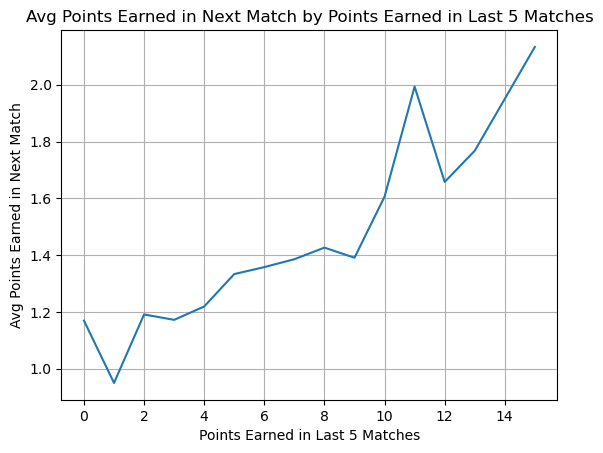

In [60]:
# we don't need to apply any sample size filters because all of the groups have a sample size much larger than 5 
plt.plot(result_by_last5points.index, result_by_last5points['PointsEarned'])
plt.xlabel("Points Earned in Last 5 Matches")
plt.ylabel("Avg Points Earned in Next Match")
plt.title("Avg Points Earned in Next Match by Points Earned in Last 5 Matches")
plt.grid(True)
plt.show()

We see a positive correlation between points earned in last 5 matches and avg points earned in next match.

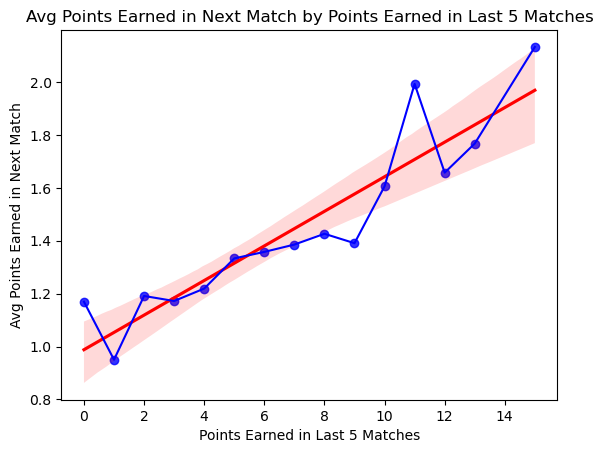

In [144]:
sns.regplot(x=result_by_last5points.index, y=result_by_last5points['PointsEarned'], color='blue', line_kws={"color": "red"})
plt.plot(result_by_last5points.index, result_by_last5points['PointsEarned'], color='blue')
plt.title("Avg Points Earned in Next Match by Points Earned in Last 5 Matches")
plt.xlabel("Points Earned in Last 5 Matches")
plt.ylabel("Avg Points Earned in Next Match")
plt.show()

In [145]:
# Calculating the slope, intercept, and r-value of the linear regression line
x = result_by_last5points.index.values
y = result_by_last5points['PointsEarned'].values

reg_line = linregress(x, y)

print('Slope:', reg_line.slope)
print('R-value:', reg_line.rvalue)

Slope: 0.0654348119292703
R-value: 0.9214492284639357


We see a strong positive correlation betwen points earned in last 5 matches and average points earned in next match. Looking at the graph we see that this correlation is the strongest when the points earned in the last 5 matches was between around 3 and 7. Before and after this the correlation is weaker.

# Q4: Does a team’s goal differential in the last n matches correlate with goal differential in the next match?

Using n = 3 and n = 5

### a) Does Goal Differential in the last 3 matches correlate with goal differential in the next match?

In [65]:
# Adding Average Goal Differential in Next Match (GoalDifferential) column to result_by_last3GD and result_by_last5GD
result_by_last3GD['GoalDifferential'] = (df.groupby('Last3GD')['GoalDifferential']).mean()
result_by_last5GD['GoalDifferential'] = (df.groupby('Last5GD')['GoalDifferential']).mean()

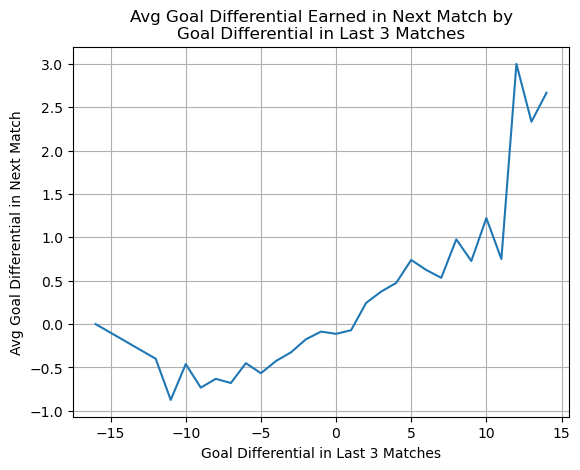

In [66]:
plt.plot(result_by_last3GD.index, result_by_last3GD['GoalDifferential'])
plt.xlabel("Goal Differential in Last 3 Matches")
plt.ylabel("Avg Goal Differential in Next Match")
plt.title("Avg Goal Differential Earned in Next Match by\nGoal Differential in Last 3 Matches")
plt.grid(True)
plt.show()

#### Requiring a minimum sample size of 5 like we did in Q1.

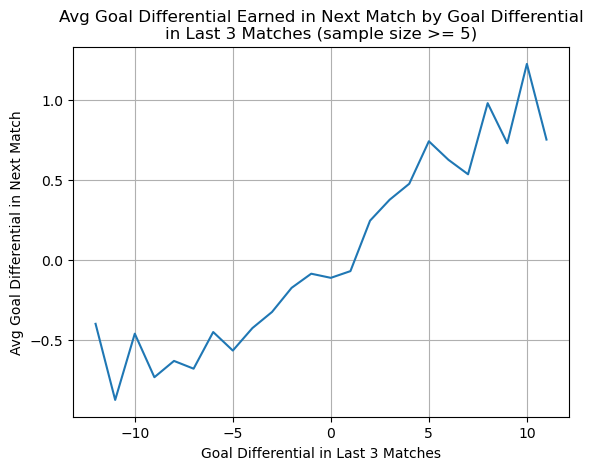

In [266]:
mask = result_by_last3GD['SampleSize'] >= 5
reduced_data = result_by_last3GD[mask]
plt.plot(reduced_data.index, reduced_data['GoalDifferential'])
plt.xlabel("Goal Differential in Last 3 Matches")
plt.ylabel("Avg Goal Differential in Next Match")
plt.title("Avg Goal Differential Earned in Next Match by Goal Differential\nin Last 3 Matches (sample size >= 5)")
plt.grid(True)
plt.show()

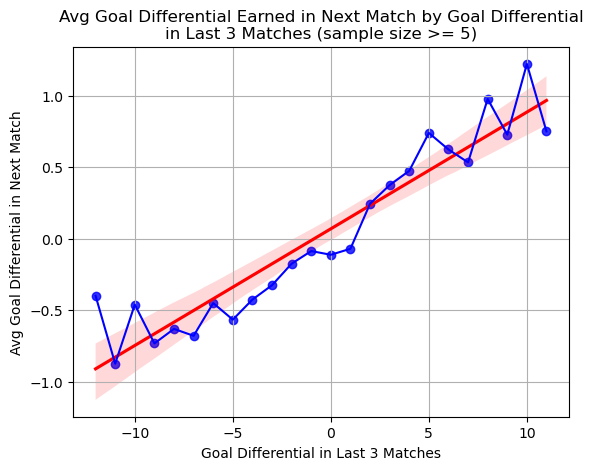

In [267]:
# Plotting with regression line
mask = result_by_last3GD['SampleSize'] >= 5
reduced_data = result_by_last3GD[mask]
sns.regplot(x=reduced_data.index, y=reduced_data['GoalDifferential'], color='blue', line_kws={"color": "red"})
plt.plot(reduced_data.index, reduced_data['GoalDifferential'], color='blue')
plt.xlabel("Goal Differential in Last 3 Matches")
plt.ylabel("Avg Goal Differential in Next Match")
plt.title("Avg Goal Differential Earned in Next Match by Goal Differential\nin Last 3 Matches (sample size >= 5)")
plt.grid(True)
plt.show()

In [141]:
# Calculating the slope, intercept, and r-value of the linear regression line
x = reduced_data.index.values
y = reduced_data['GoalDifferential'].values

reg_line = linregress(x, y)

print('Slope:', reg_line.slope)
print('R-value:', reg_line.rvalue)

Slope: 0.08164838863707448
R-value: 0.9456170265953291


We see a strong positive correlation between goal differential in last 3 matches and average goal differential in next match.

### b) Does Goal Differential in the last 5 matches correlate goal differential in the next match?

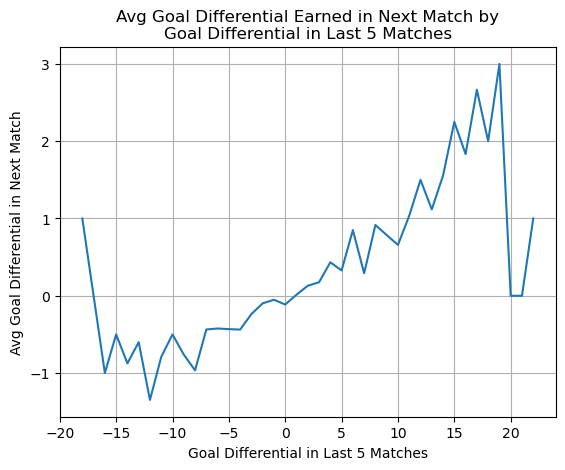

In [70]:
plt.plot(result_by_last5GD.index, result_by_last5GD['GoalDifferential'])
plt.xlabel("Goal Differential in Last 5 Matches")
plt.ylabel("Avg Goal Differential in Next Match")
plt.title("Avg Goal Differential Earned in Next Match by\nGoal Differential in Last 5 Matches")
plt.grid(True)
plt.show()

#### Requiring minimum sample size of 5 again.

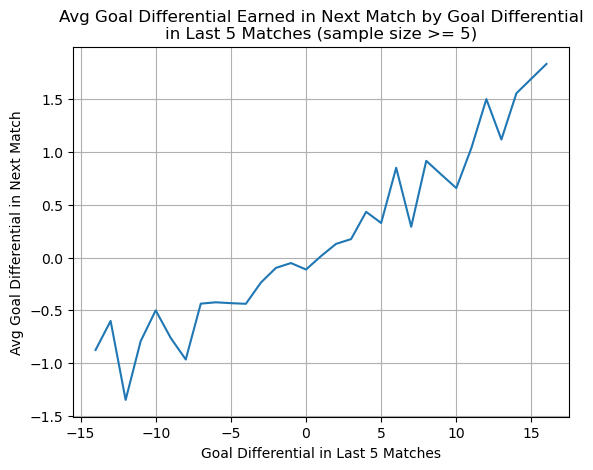

In [268]:
mask = result_by_last5GD['SampleSize'] >= 5
reduced_data = result_by_last5GD[mask]
plt.plot(reduced_data.index, reduced_data['GoalDifferential'])
plt.xlabel("Goal Differential in Last 5 Matches")
plt.ylabel("Avg Goal Differential in Next Match")
plt.title("Avg Goal Differential Earned in Next Match by Goal Differential\nin Last 5 Matches (sample size >= 5)")
plt.grid(True)
plt.show()

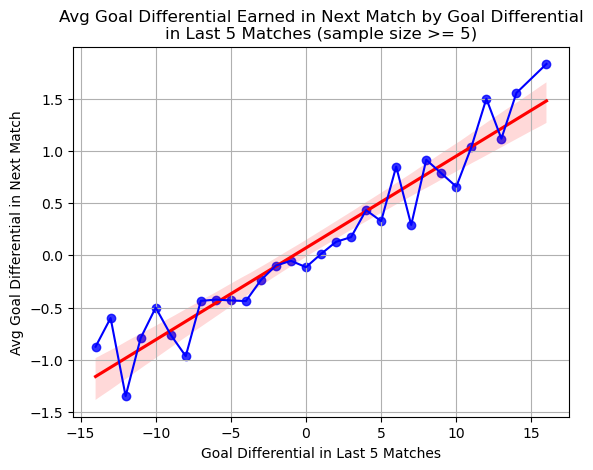

In [269]:
# Plotting with regression line
mask = result_by_last5GD['SampleSize'] >= 5
reduced_data = result_by_last5GD[mask]
sns.regplot(x=reduced_data.index, y=reduced_data['GoalDifferential'], color='blue', line_kws={"color": "red"})
plt.plot(reduced_data.index, reduced_data['GoalDifferential'], color='blue')
plt.xlabel("Goal Differential in Last 5 Matches")
plt.ylabel("Avg Goal Differential in Next Match")
plt.title("Avg Goal Differential Earned in Next Match by Goal Differential\nin Last 5 Matches (sample size >= 5)")
plt.grid(True)
plt.show()

In [139]:
# Calculating the slope and r-value of the linear regression line (of data where sample size > 4)
x = reduced_data.index.values
y = reduced_data['GoalDifferential'].values

reg_line = linregress(x, y)

print('Slope:', reg_line.slope)
print('R-value:', reg_line.rvalue)

Slope: 0.08798639610375465
R-value: 0.960052859361458


We see a very strong positive correlation between goal differential in the last 5 matches and average goal differential in the next match. Looking at the graph, there is a very strong correlation when the goal differential in the last 5 matches was beteen -5 and 4.

# Q5: Does a team's goal differential in the last n games correlate with match outcome?

using n = 3 and n = 5

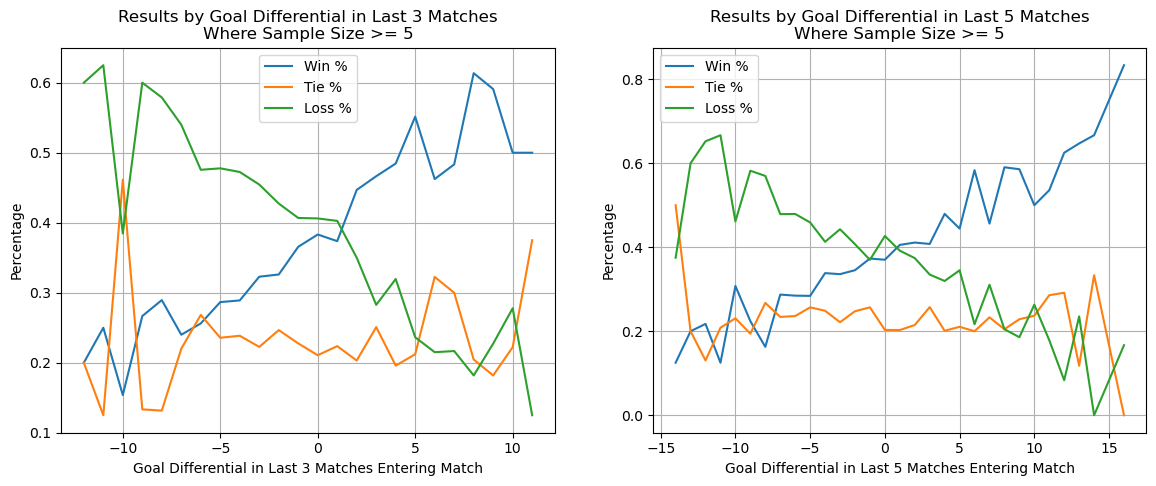

In [273]:
# Plotting graph for results by goal differential in last n matches where n = 3 and 5 (where sample size still has to to be > 4)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

mask1 = result_by_last3GD['SampleSize'] >= 5
reduced_data1 = result_by_last3GD[mask1]

axes[0].plot(reduced_data1.index, reduced_data1['WinPercentage'], label='Win %')
axes[0].plot(reduced_data1.index, reduced_data1['TiePercentage'], label='Tie %')
axes[0].plot(reduced_data1.index, reduced_data1['LossPercentage'], label='Loss %')

axes[0].set_xlabel("Goal Differential in Last 3 Matches Entering Match")
axes[0].set_ylabel("Percentage")
axes[0].set_title("Results by Goal Differential in Last 3 Matches\nWhere Sample Size >= 5")
axes[0].grid(True)
axes[0].legend()

mask2 = result_by_last5GD['SampleSize'] >= 5
reduced_data2 = result_by_last5GD[mask2]

axes[1].plot(reduced_data2.index, reduced_data2['WinPercentage'], label='Win %')
axes[1].plot(reduced_data2.index, reduced_data2['TiePercentage'], label='Tie %')
axes[1].plot(reduced_data2.index, reduced_data2['LossPercentage'], label='Loss %')

axes[1].set_xlabel("Goal Differential in Last 5 Matches Entering Match")
axes[1].set_ylabel("Percentage")
axes[1].set_title("Results by Goal Differential in Last 5 Matches\nWhere Sample Size >= 5")
axes[1].grid(True)
axes[1].legend()

plt.show()

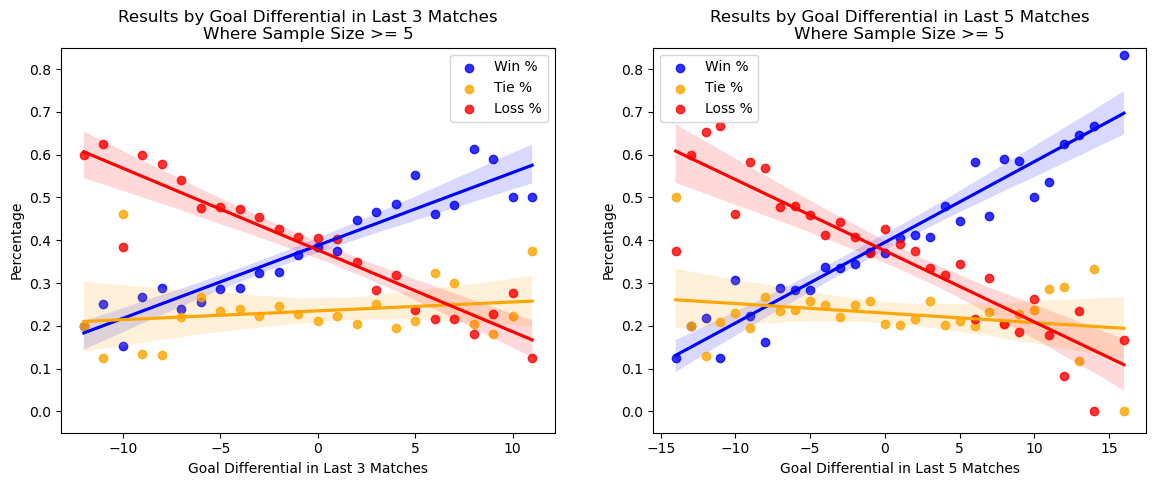

In [284]:
# Plotting regression line plots from Q1 and Q2 beside each other
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

mask1 = result_by_last3GD['SampleSize'] >= 5
reduced_data1 = result_by_last3GD[mask1]

sns.regplot(x=reduced_data1.index, y=reduced_data1['WinPercentage'], color='blue', line_kws={'color': 'blue'}, label='Win %', ax=axes[0])
sns.regplot(x=reduced_data1.index, y=reduced_data1['TiePercentage'], color='orange', line_kws={'color': 'orange'}, label='Tie %', ax=axes[0])
sns.regplot(x=reduced_data1.index, y=reduced_data1['LossPercentage'], color='red', line_kws={'color': 'red'}, label='Loss %', ax=axes[0])
axes[0].set_xlabel("Goal Differential in Last 3 Matches")
axes[0].set_ylabel("Percentage")
axes[0].set_title("Results by Goal Differential in Last 3 Matches\nWhere Sample Size >= 5")
axes[0].set_ylim(-.05,0.85)
axes[0].legend()

mask2 = result_by_last5GD['SampleSize'] >= 5
reduced_data2 = result_by_last5GD[mask2]

sns.regplot(x=reduced_data2.index, y=reduced_data2['WinPercentage'], color='blue', line_kws={'color': 'blue'}, label='Win %', ax=axes[1])
sns.regplot(x=reduced_data2.index, y=reduced_data2['TiePercentage'], color='orange', line_kws={'color': 'orange'}, label='Tie %', ax=axes[1])
sns.regplot(x=reduced_data2.index, y=reduced_data2['LossPercentage'], color='red', line_kws={'color': 'red'}, label='Loss %', ax=axes[1])

axes[1].set_xlabel("Goal Differential in Last 5 Matches")
axes[1].set_ylabel("Percentage")
axes[1].set_title("Results by Goal Differential in Last 5 Matches\nWhere Sample Size >= 5")
axes[1].set_ylim(-.05,0.85)
axes[1].legend()

plt.show()

In [135]:
# calculating slope and r-value of linaer regression lines and putting in df to display
results = []
metric1 = 'GD in Last 3 Matches'
x1 = reduced_data1.index.values
reg_data1 = {'Win': reduced_data1['WinPercentage'].values, 'Tie': reduced_data1['TiePercentage'].values, 'Loss': reduced_data1['LossPercentage'].values}
for name, y1 in reg_data1.items():
    reg_line1 = linregress(x1, y1)
    results.append({'Metric': metric1,'Result': name,'Slope': reg_line1.slope,'R-value': reg_line1.rvalue})

metric2 = 'GD in Last 5 Matches'
x2 = reduced_data2.index.values
reg_data2 = {'Win': reduced_data2['WinPercentage'].values, 'Tie': reduced_data2['TiePercentage'].values, 'Loss': reduced_data2['LossPercentage'].values}
for name, y2 in reg_data2.items():
    reg_line2 = linregress(x2, y2)
    results.append({'Metric': metric2,'Result': name,'Slope': reg_line2.slope,'R-value': reg_line2.rvalue})

results_df = pd.DataFrame(results)
results_df

Metric Result     Slope   R-value
0  GD in Last 3 Matches    Win  0.017046  0.940836
1  GD in Last 3 Matches    Tie  0.002065  0.196690
2  GD in Last 3 Matches   Loss -0.019111 -0.931092
3  GD in Last 5 Matches    Win  0.018871  0.956446
4  GD in Last 5 Matches    Tie -0.002222 -0.251779
5  GD in Last 5 Matches   Loss -0.016648 -0.901554

There is a strong positive correlation between goal differential in the last n matches (where n is 3 and 5) and win percentage. There is a slightly stronger correlation when n is 5. There is a strong negative correlation between goal differential in last n matches (where n is 3 and 5) and loss percentage. There is a stronger correlation when n is 3. There is not much of a correlation between goal differential in the last n matches (where n is 3 and 5) and tie percentage. It is interesting that there is a stronger correlation with win percentage when n is 5 but a stronger correlation with loss percentage when n is 3. A logical explanation for this is that positive momentum takes longer to build, but negative momentum takes less time to build. Additionally, we can conclude that there is not much correlation to tie percentage and thus tie percentage can't be predicted based of recent goal differential.

# Q6: Does negative momentum correlate with match outcome?

### We will use loss streaks and games since win as negative momentum

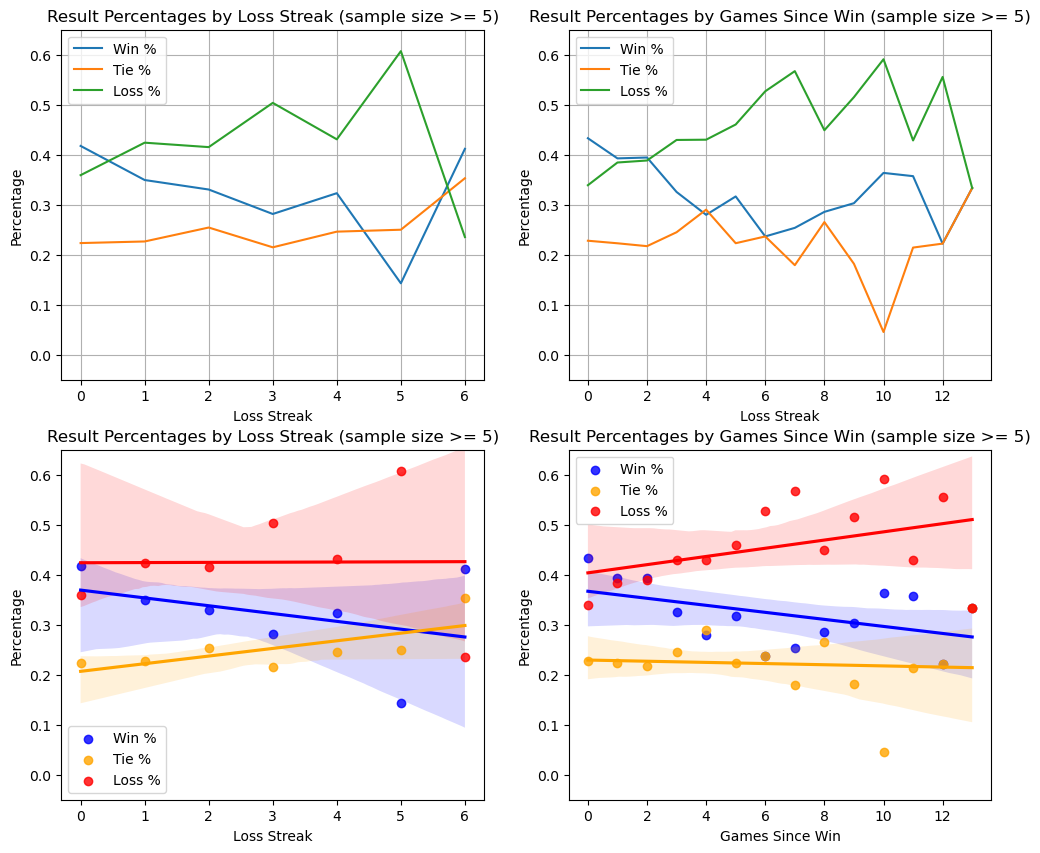

In [379]:
# Plotting line charts and regression line plots for loss streak and games since win; requiring original minimum sample size of 5
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

samplesize_mask = result_by_lossstreak['SampleSize'] >= 5
lossstreak_reduced_data = result_by_lossstreak[samplesize_mask]

axes[0,0].plot(lossstreak_reduced_data.index, lossstreak_reduced_data['WinPercentage'], label='Win %')
axes[0,0].plot(lossstreak_reduced_data.index, lossstreak_reduced_data['TiePercentage'], label='Tie %')
axes[0,0].plot(lossstreak_reduced_data.index, lossstreak_reduced_data['LossPercentage'], label='Loss %')
axes[0,0].set_xlabel("Loss Streak")
axes[0,0].set_ylabel("Percentage")
axes[0,0].set_title("Result Percentages by Loss Streak (sample size >= 5)")
axes[0,0].grid(True)
axes[0,0].legend()
axes[0,0].set_ylim(-.05,.65)

samplesize_mask = result_by_gamessincewin['SampleSize'] >= 5
gamessincewin_reduced_data = result_by_gamessincewin[samplesize_mask]

axes[0,1].plot(gamessincewin_reduced_data.index, gamessincewin_reduced_data['WinPercentage'], label='Win %')
axes[0,1].plot(gamessincewin_reduced_data.index, gamessincewin_reduced_data['TiePercentage'], label='Tie %')
axes[0,1].plot(gamessincewin_reduced_data.index, gamessincewin_reduced_data['LossPercentage'], label='Loss %')
axes[0,1].set_xlabel("Loss Streak")
axes[0,1].set_ylabel("Percentage")
axes[0,1].set_title("Result Percentages by Games Since Win (sample size >= 5)")
axes[0,1].grid(True)
axes[0,1].legend()
axes[0,1].set_ylim(-.05,.65)

sns.regplot(x=lossstreak_reduced_data.index, y=lossstreak_reduced_data['WinPercentage'], color='blue', line_kws={'color': 'blue'}, label='Win %', ax=axes[1,0])
sns.regplot(x=lossstreak_reduced_data.index, y=lossstreak_reduced_data['TiePercentage'], color='orange', line_kws={'color': 'orange'}, label='Tie %', ax=axes[1,0])
sns.regplot(x=lossstreak_reduced_data.index, y=lossstreak_reduced_data['LossPercentage'], color='red', line_kws={'color': 'red'}, label='Loss %', ax=axes[1,0])
axes[1,0].set_xlabel("Loss Streak")
axes[1,0].set_ylabel("Percentage")
axes[1,0].set_title('Result Percentages by Loss Streak (sample size >= 5)')
axes[1,0].set_ylim(-.05, .65)
axes[1,0].legend()

sns.regplot(x=gamessincewin_reduced_data.index, y=gamessincewin_reduced_data['WinPercentage'], color='blue', line_kws={'color': 'blue'}, label='Win %', ax=axes[1,1])
sns.regplot(x=gamessincewin_reduced_data.index, y=gamessincewin_reduced_data['TiePercentage'], color='orange', line_kws={'color': 'orange'}, label='Tie %', ax=axes[1,1])
sns.regplot(x=gamessincewin_reduced_data.index, y=gamessincewin_reduced_data['LossPercentage'], color='red', line_kws={'color': 'red'}, label='Loss %', ax=axes[1,1])
axes[1,1].set_xlabel("Games Since Win")
axes[1,1].set_ylabel("Percentage")
axes[1,1].set_title('Result Percentages by Games Since Win (sample size >= 5)')
axes[1,1].set_ylim(-.05, .65)
axes[1,1].legend()

In [380]:
# calculating slope and r-value of linaer regression lines and putting in df to display
results = []

metric1 = 'Loss Streak (Sample Size >= 5)'
x1 = lossstreak_reduced_data.index.values
reg_data1 = {'Win': lossstreak_reduced_data['WinPercentage'].values, 'Tie': lossstreak_reduced_data['TiePercentage'].values, 'Loss': lossstreak_reduced_data['LossPercentage'].values}
for name, y1 in reg_data1.items():
    reg_line1 = linregress(x1, y1)
    results.append({'Metric': metric1,'Result': name,'Slope': reg_line1.slope,'R-value': reg_line1.rvalue})

metric2 = 'Games Since Win (Sample Size >= 5)'
x2 = gamessincewin_reduced_data.index.values
reg_data2 = {'Win': gamessincewin_reduced_data['WinPercentage'].values, 'Tie': gamessincewin_reduced_data['TiePercentage'].values, 'Loss': gamessincewin_reduced_data['LossPercentage'].values}
for name, y2 in reg_data2.items():
    reg_line2 = linregress(x2, y2)
    results.append({'Metric': metric2,'Result': name,'Slope': reg_line2.slope,'R-value': reg_line2.rvalue})

results_df = pd.DataFrame(results)
results_df

Metric Result     Slope   R-value
0      Loss Streak (Sample Size >= 5)    Win -0.015638 -0.363748
1      Loss Streak (Sample Size >= 5)    Tie  0.015275  0.706523
2      Loss Streak (Sample Size >= 5)   Loss  0.000363  0.006798
3  Games Since Win (Sample Size >= 5)    Win -0.007029 -0.469180
4  Games Since Win (Sample Size >= 5)    Tie -0.001170 -0.075645
5  Games Since Win (Sample Size >= 5)   Loss  0.008199  0.413166

We see a slight correlation betwen match negative momentum and match results. Although these correlations are much weaker than all of the positive momentum metrics. The strongest correlation is between loss streak and tie %. This is interesting because all of the momentum metrics got much weaker correlation with tie % then win % or loss %.

# Q7. What Momentum Metric is the Best Indicator of Match Outcome?

### We have looked at the following momentum metrics: win streak, unbeaten streak, points earned in the last 3 games, points earned in the last 5 games, goal differential in the last 3 games, goal differential in the last 5 games, loss streak (negative) , and games since win (negative)

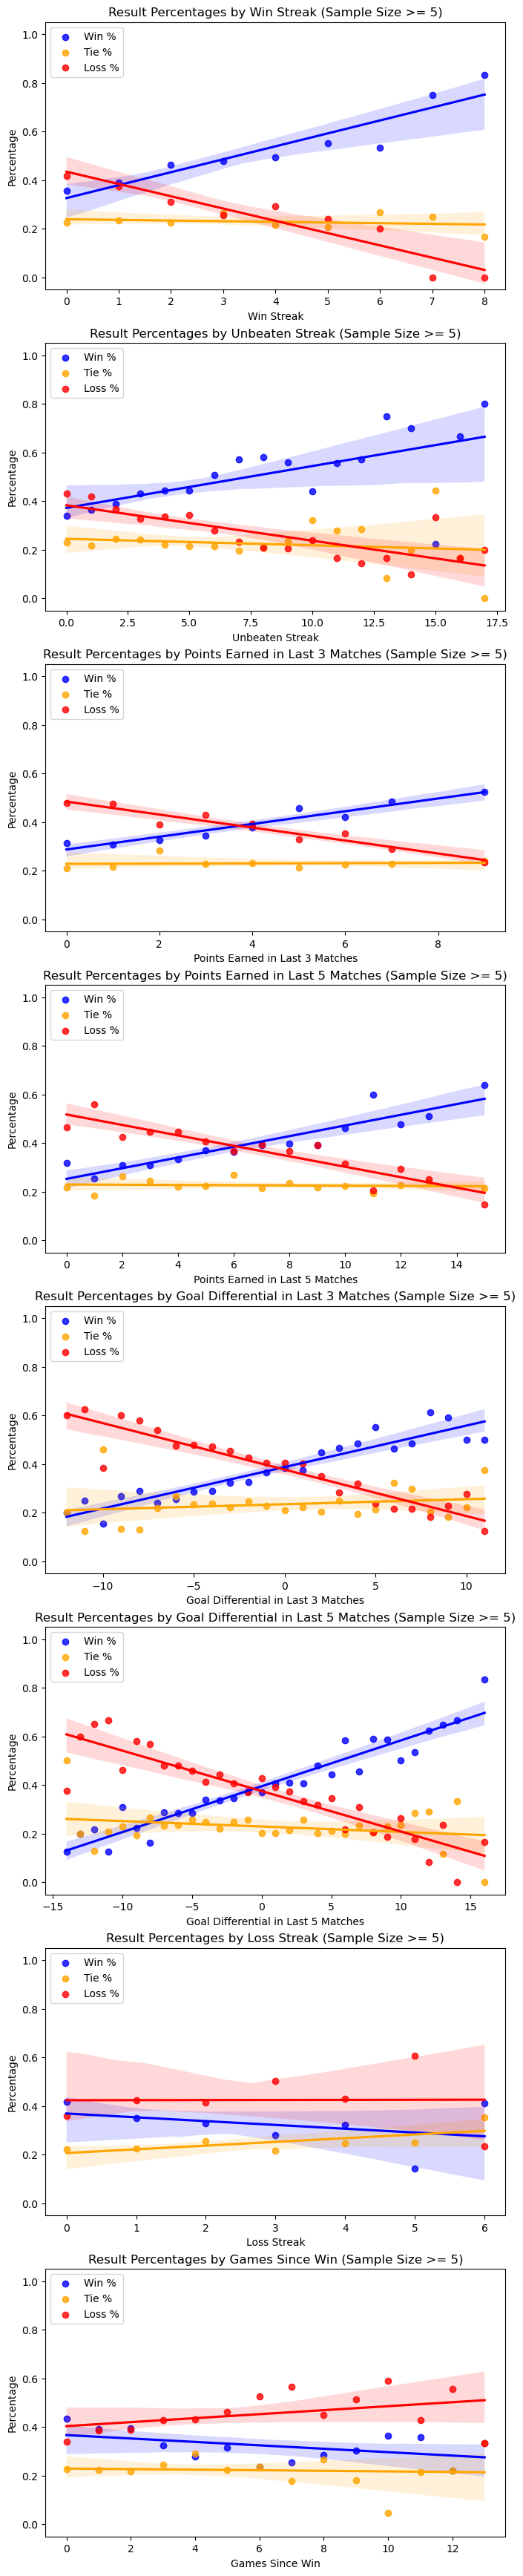

In [381]:
# Plotting regression line plots
fig, axes = plt.subplots(8, 1, figsize=(8,44))

momentum_metrics = {'Win Streak': result_by_winstreak, 'Unbeaten Streak': result_by_unbeatenstreak, 'Points Earned in Last 3 Matches': result_by_last3points,
          'Points Earned in Last 5 Matches': result_by_last5points, 'Goal Differential in Last 3 Matches': result_by_last3GD, 
          'Goal Differential in Last 5 Matches': result_by_last5GD, 'Loss Streak': result_by_lossstreak, 'Games Since Win': result_by_gamessincewin}

i = 0
for name, curr_metric_df in momentum_metrics.items():
    mask = curr_metric_df['SampleSize'] >= 5
    reduced_data = curr_metric_df[mask]
    
    sns.regplot(x=reduced_data.index, y=reduced_data['WinPercentage'], color='blue', line_kws={'color': 'blue'}, label='Win %', ax=axes[i])
    sns.regplot(x=reduced_data.index, y=reduced_data['TiePercentage'], color='orange', line_kws={'color': 'orange'}, label='Tie %', ax=axes[i]) 
    sns.regplot(x=reduced_data.index, y=reduced_data['LossPercentage'], color='red', line_kws={'color': 'red'}, label='Loss %', ax=axes[i])
    axes[i].set_xlabel(name)
    axes[i].set_ylabel("Percentage")
    axes[i].set_ylim(-.05, 1.05)
    axes[i].set_title(f'Result Percentages by {name} (Sample Size >= 5)')
    axes[i].legend(loc = 'upper left')

    i += 1
    
plt.show()

In [382]:
results = []
for name, curr_metric_df in momentum_metrics.items():
    mask = curr_metric_df['SampleSize'] > 4
    reduced_data = curr_metric_df[mask]

    x = reduced_data.index.values
    reg_data = {'Win': reduced_data['WinPercentage'].values, 'Tie': reduced_data['TiePercentage'].values, 'Loss': reduced_data['LossPercentage'].values}
    for result, y in reg_data.items():
        reg_line = linregress(x, y)
        results.append({'Metric': name, 'Result': result,'Slope': reg_line.slope, 'R-value': reg_line.rvalue}) 

results_df = pd.DataFrame(results)
results_df

Metric Result     Slope   R-value
0                            Win Streak    Win  0.053217  0.927035
1                            Win Streak    Tie -0.002702 -0.237833
2                            Win Streak   Loss -0.050515 -0.938197
3                       Unbeaten Streak    Win  0.017209  0.609233
4                       Unbeaten Streak    Tie -0.002649 -0.155587
5                       Unbeaten Streak   Loss -0.014560 -0.790248
6       Points Earned in Last 3 Matches    Win  0.026221  0.959847
7       Points Earned in Last 3 Matches    Tie  0.000491  0.066122
8       Points Earned in Last 3 Matches   Loss -0.026712 -0.957717
9       Points Earned in Last 5 Matches    Win  0.021969  0.916025
10      Points Earned in Last 5 Matches    Tie -0.000471 -0.095674
11      Points Earned in Last 5 Matches   Loss -0.021498 -0.919356
12  Goal Differential in Last 3 Matches    Win  0.017046  0.940836
13  Goal Differential in Last 3 Matches    Tie  0.002065  0.196690
14  Goal Differential in Last 3 Matches   Loss -0.019111 -0.931092
15  Goal Differential in Last 5 Matches    Win  0.018871  0.956446
16  Goal Differential in Last 5 Matches    Tie -0.002222 -0.251779
17  Goal Differential in Last 5 Matches   Loss -0.016648 -0.901554
18                          Loss Streak    Win -0.015638 -0.363748
19                          Loss Streak    Tie  0.015275  0.706523
20                          Loss Streak   Loss  0.000363  0.006798
21                      Games Since Win    Win -0.007029 -0.469180
22                      Games Since Win    Tie -0.001170 -0.075645
23                      Games Since Win   Loss  0.008199  0.413166

In [383]:
max_win_rvalue = results_df[results_df['Result'] == 'Win']['R-value'].max()
max_win_metric = results_df[results_df['R-value'] == max_win_rvalue]['Metric']
max_tie_rvalue = abs(results_df[results_df['Result'] == 'Tie']['R-value']).max()
max_tie_metric = results_df[results_df['R-value'] == max_tie_rvalue]['Metric']
max_loss_rvalue = results_df[results_df['Result'] == 'Loss']['R-value'].min() # we see that the strongest loss % correlations are negative so finding min
max_loss_metric = results_df[results_df['R-value'] == max_loss_rvalue]['Metric']

In [384]:
print(f'Max Win R-value: {max_win_rvalue}')
print(f'Strongest Win Correlation Metric: {max_win_metric}')
print(f'Max Tie R-value: {max_tie_rvalue}')
print(f'Strongest Tie Correlation Metric: {max_tie_metric}')
print(f'Max R-value: {max_loss_rvalue}')
print(f'Strongest Loss Correlation Metric: {max_loss_metric}')

Max Win R-value: 0.9598467196688868
Strongest Win Correlation Metric: 6    Points Earned in Last 3 Matches
Name: Metric, dtype: object
Max Tie R-value: 0.7065231036911638
Strongest Tie Correlation Metric: 19    Loss Streak
Name: Metric, dtype: object
Max R-value: -0.9577170782936103
Strongest Loss Correlation Metric: 8    Points Earned in Last 3 Matches
Name: Metric, dtype: object


We see that the strongest win % correlation was .960 with points earned in the last 3 matches (although goal differential in last 5 matches is a close second). Strongest tie % correlation was just was .707 with loss streak (this was by far the strongest correlation). Strong loss % correlation is -.958 with points earned in last 3 matches. Overall, points earned in the last 3 matches has the strongest correlation with match outcome. We can also conclude that there are much stronger correlations with momentum metrics and winn % and loss % than tie %.

# Q8: Does the effect of momentum differ for ‘big’ clubs vs ‘small’ clubs?

In the premier league Arsenal, Manchester City, Manchester United, Liverpool, Chelsea, and Tottenham (Spurs) are often reffered to as the "Big 6" because of their sustained success and financial strength. Historically, these 6 clubs have accounted for over half of the total annual revenue generated by Premier League clubs (since 2004). We will refer to these 6 teams as 'big' clubs and the rest of the clubs as "small" clubs. Read more about the "Big 6" here: https://en.wikipedia.org/wiki/Big_Six_(Premier_League)

#### We are going to use the three momentum metrics we have used so far: win streak, unbeaten streak, points earned in the last n games, and goal differential in the last n games (where n is 3 or 5). We are change the minimum sample requirement from 5 to 3 because now there is less data in each dataframe.

### First we have to create new result by momentum metric dataframes (two for each where one contains big 6 teams, one doesn't)

In [79]:
# Creating big 6 df and non big 6 df
big6 = ['Arsenal', 'Manchester City', 'Manchester United', 'Chelsea', 'Spurs', 'Liverpool']
df_big6 = df[df['Team'].isin(big6)]
df_other = df[df['Team'].isin(big6) == False]

In [80]:
# function that creates df grouped by momentum metrics and big 6 or non big, and shows win %, tie %, and loss % for each group
def create_result_df_by_size(metric, size): # size has to be 'big' or 'small'
    if size == 'big':
        groups = df_big6.groupby(metric)
        group_counts = groups.size()
        result_by_metric = group_counts.to_frame() # Transforming series of win streak counts to dataframe
        result_by_metric.columns = ['SampleSize'] #Naming column
        result_by_metric['WinPercentage'] = (df_big6.groupby(metric)['Result'].apply(lambda x: (x == 'W').mean())) # Calculating WinPercentage by Metric
        result_by_metric['TiePercentage'] = (df_big6.groupby(metric)['Result'].apply(lambda x: (x == 'T').mean())) # Calculating TiePercentage by Metric
        result_by_metric['LossPercentage'] = (df_big6.groupby(metric)['Result'].apply(lambda x: (x == 'L').mean())) # Calculating LossPercentage by Metric
    elif size == 'small':
        groups = df_other.groupby(metric)
        group_counts = groups.size()
        result_by_metric = group_counts.to_frame() # Transforming series of win streak counts to dataframe
        result_by_metric.columns = ['SampleSize'] #Naming column
        result_by_metric['WinPercentage'] = (df_other.groupby(metric)['Result'].apply(lambda x: (x == 'W').mean())) # Calculating WinPercentage by Metric
        result_by_metric['TiePercentage'] = (df_other.groupby(metric)['Result'].apply(lambda x: (x == 'T').mean())) # Calculating TiePercentage by Metric
        result_by_metric['LossPercentage'] = (df_other.groupby(metric)['Result'].apply(lambda x: (x == 'L').mean())) # Calculating LossPercentage by Metric
    else:
        return

    return result_by_metric

big6_result_by_winstreak = create_result_df_by_size('WinStreakBefore', 'big')
other_result_by_winstreak = create_result_df_by_size('WinStreakBefore','small')
big6_result_by_unbeatenstreak = create_result_df_by_size('UnbeatenStreakBefore', 'big')
other_result_by_unbeatenstreak = create_result_df_by_size('UnbeatenStreakBefore','small')
big6_result_by_last3points = create_result_df_by_size('Last3Points','big')
other_result_by_last3points = create_result_df_by_size('Last3Points','small')
big6_result_by_last5points = create_result_df_by_size('Last5Points','big')
other_result_by_last5points = create_result_df_by_size('Last5Points','small')
big6_result_by_last3GD = create_result_df_by_size('Last3GD','big')
other_result_by_last3GD = create_result_df_by_size('Last3GD','small')
big6_result_by_last5GD = create_result_df_by_size('Last5GD','big')     
other_result_by_last5GD = create_result_df_by_size('Last5GD','small') 

In [81]:
# example of what these dataframes look like
big6_result_by_winstreak # this data just includes "Big 6" teams

SampleSize  WinPercentage  TiePercentage  LossPercentage
WinStreakBefore                                                          
0                       367       0.514986       0.188011        0.297003
1                       182       0.549451       0.241758        0.208791
2                        98       0.591837       0.204082        0.204082
3                        56       0.571429       0.214286        0.214286
4                        32       0.468750       0.281250        0.250000
5                        12       0.500000       0.166667        0.333333
6                         5       0.800000       0.200000        0.000000
7                         4       0.500000       0.500000        0.000000
8                         2       0.500000       0.500000        0.000000
9                         1       1.000000       0.000000        0.000000
10                        1       0.000000       1.000000        0.000000

### We will change the minimum sample size requirement from 5 to 3 to not lose to much data (because now the data is broken up)

### a) Using Win Streak as the Momentum Metric

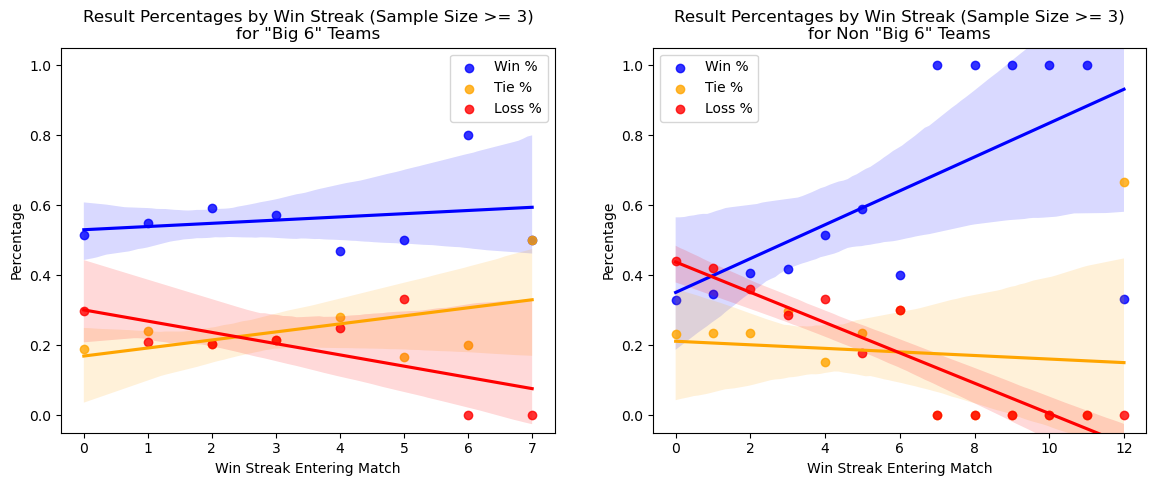

In [132]:
# Plotting regression line plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

big6_mask = big6_result_by_winstreak['SampleSize'] >= 3
big6_reduced_data = big6_result_by_winstreak[big6_mask]

sns.regplot(x=big6_reduced_data.index, y=big6_reduced_data['WinPercentage'], color='blue', line_kws={'color': 'blue'}, label='Win %', ax=axes[0])
sns.regplot(x=big6_reduced_data.index, y=big6_reduced_data['TiePercentage'], color='orange', line_kws={'color': 'orange'}, label='Tie %', ax=axes[0])
sns.regplot(x=big6_reduced_data.index, y=big6_reduced_data['LossPercentage'], color='red', line_kws={'color': 'red'}, label='Loss %', ax=axes[0])
axes[0].set_xlabel("Win Streak Entering Match")
axes[0].set_ylabel("Percentage")
axes[0].set_title('Result Percentages by Win Streak (Sample Size >= 3)\nfor "Big 6" Teams')
axes[0].set_ylim(-.05,1.05)
axes[0].legend()


other_mask = other_result_by_winstreak['SampleSize'] >= 3
other_reduced_data = other_result_by_winstreak[other_mask]

sns.regplot(x=other_reduced_data.index, y=other_reduced_data['WinPercentage'], color='blue', line_kws={'color': 'blue'}, label='Win %', ax=axes[1])
sns.regplot(x=other_reduced_data.index, y=other_reduced_data['TiePercentage'], color='orange', line_kws={'color': 'orange'}, label='Tie %', ax=axes[1])
sns.regplot(x=other_reduced_data.index, y=other_reduced_data['LossPercentage'], color='red', line_kws={'color': 'red'}, label='Loss %', ax=axes[1])
axes[1].set_xlabel("Win Streak Entering Match")
axes[1].set_ylabel("Percentage")
axes[1].set_title('Result Percentages by Win Streak (Sample Size >= 3)\nfor Non "Big 6" Teams')
axes[1].set_ylim(-.05,1.05)
axes[1].legend()

plt.show()

In [133]:
# calculating slope intercept, and r-value of linaer regression lines and putting in df to display
results = []
metric1 = 'Winstreak for "Big 6 Teams"'
x1 = big6_reduced_data.index.values
reg_data1 = {'Win': big6_reduced_data['WinPercentage'].values, 'Tie': big6_reduced_data['TiePercentage'].values, 'Loss': big6_reduced_data['LossPercentage'].values}
for name, y1 in reg_data1.items():
    reg_line1 = linregress(x1, y1)
    results.append({'Metric': metric1,'Result': name,'Slope': reg_line1.slope, 'R-value': reg_line1.rvalue})

metric2 = 'Winstreak for Non "Big 6 Teams"'
x2 = other_reduced_data.index.values
reg_data2 = {'Win': other_reduced_data['WinPercentage'].values, 'Tie': other_reduced_data['TiePercentage'].values, 'Loss': other_reduced_data['LossPercentage'].values}
for name, y2 in reg_data2.items():
    reg_line2 = linregress(x2, y2)
    results.append({'Metric': metric2,'Result': name,'Slope': reg_line2.slope, 'R-value': reg_line2.rvalue})

results_df = pd.DataFrame(results)
results_df

Metric Result     Slope   R-value
0      Winstreak for "Big 6 Teams"    Win  0.009163  0.214866
1      Winstreak for "Big 6 Teams"    Tie  0.022974  0.525709
2      Winstreak for "Big 6 Teams"   Loss -0.032137 -0.631080
3  Winstreak for Non "Big 6 Teams"    Win  0.048382  0.620659
4  Winstreak for Non "Big 6 Teams"    Tie -0.005089 -0.103564
5  Winstreak for Non "Big 6 Teams"   Loss -0.043293 -0.922354

We see that non-big 6 teams have a greater correlation between win streak and win % (positive correlation) and win streak and loss % (negative correlation) (as seen by the greater r values). We do see a much greater correlation between win streak and loss percentage then win streak and win percentage for both of these. However, big 6 teams have a greater correlation between tie % and wins streak (positive correlation).

### b) Using Unbeaten Streak as the Momentum Metric

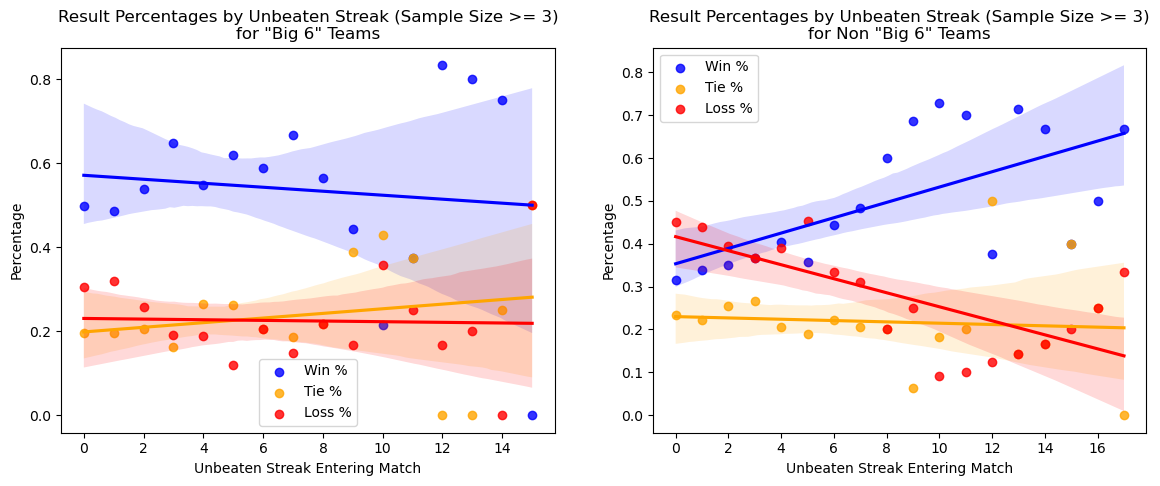

In [130]:
# Plotting regression line plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

big6_mask = big6_result_by_unbeatenstreak['SampleSize'] >= 3
big6_reduced_data = big6_result_by_unbeatenstreak[big6_mask]

sns.regplot(x=big6_reduced_data.index, y=big6_reduced_data['WinPercentage'], color='blue', line_kws={'color': 'blue'}, label='Win %', ax=axes[0])
sns.regplot(x=big6_reduced_data.index, y=big6_reduced_data['TiePercentage'], color='orange', line_kws={'color': 'orange'}, label='Tie %', ax=axes[0])
sns.regplot(x=big6_reduced_data.index, y=big6_reduced_data['LossPercentage'], color='red', line_kws={'color': 'red'}, label='Loss %', ax=axes[0])
axes[0].set_xlabel("Unbeaten Streak Entering Match")
axes[0].set_ylabel("Percentage")
axes[0].set_title('Result Percentages by Unbeaten Streak (Sample Size >= 3)\nfor "Big 6" Teams')
axes[0].legend()


other_mask = other_result_by_unbeatenstreak['SampleSize'] >= 3
other_reduced_data = other_result_by_unbeatenstreak[other_mask]

sns.regplot(x=other_reduced_data.index, y=other_reduced_data['WinPercentage'], color='blue', line_kws={'color': 'blue'}, label='Win %', ax=axes[1])
sns.regplot(x=other_reduced_data.index, y=other_reduced_data['TiePercentage'], color='orange', line_kws={'color': 'orange'}, label='Tie %', ax=axes[1])
sns.regplot(x=other_reduced_data.index, y=other_reduced_data['LossPercentage'], color='red', line_kws={'color': 'red'}, label='Loss %', ax=axes[1])
axes[1].set_xlabel("Unbeaten Streak Entering Match")
axes[1].set_ylabel("Percentage")
axes[1].set_title('Result Percentages by Unbeaten Streak (Sample Size >= 3)\nfor Non "Big 6" Teams')
axes[1].set_xticks(range(0,18,2))
axes[1].legend()

plt.show()

In [131]:
# calculating slope and r-value of linaer regression lines and putting in df to display
results = []
metric1 = 'Unbeaten Streak for "Big 6 Teams"'
x1 = big6_reduced_data.index.values
reg_data1 = {'Win': big6_reduced_data['WinPercentage'].values, 'Tie': big6_reduced_data['TiePercentage'].values, 'Loss': big6_reduced_data['LossPercentage'].values}
for name, y1 in reg_data1.items():
    reg_line1 = linregress(x1, y1)
    results.append({'Metric': metric1,'Result': name,'Slope': reg_line1.slope, 'R-value': reg_line1.rvalue})

metric2 = 'Unbeaten Streak for Non "Big 6 Teams"'
x2 = other_reduced_data.index.values
reg_data2 = {'Win': other_reduced_data['WinPercentage'].values, 'Tie': other_reduced_data['TiePercentage'].values, 'Loss': other_reduced_data['LossPercentage'].values}
for name, y2 in reg_data2.items():
    reg_line2 = linregress(x2, y2)
    results.append({'Metric': metric2,'Result': name,'Slope': reg_line2.slope,'R-value': reg_line2.rvalue})

results_df = pd.DataFrame(results)
results_df

Metric Result     Slope   R-value
0      Unbeaten Streak for "Big 6 Teams"    Win -0.004743 -0.106597
1      Unbeaten Streak for "Big 6 Teams"    Tie  0.005517  0.193664
2      Unbeaten Streak for "Big 6 Teams"   Loss -0.000774 -0.032884
3  Unbeaten Streak for Non "Big 6 Teams"    Win  0.017893  0.625597
4  Unbeaten Streak for Non "Big 6 Teams"    Tie -0.001536 -0.075472
5  Unbeaten Streak for Non "Big 6 Teams"   Loss -0.016357 -0.703668

We see that non "big-6" teams have a stronger correlation between result and unbeaten streak.

### c) Using Points Earned in the Last N Matches (n = 3 or 5) as the Momentum Metric

### n = 3:

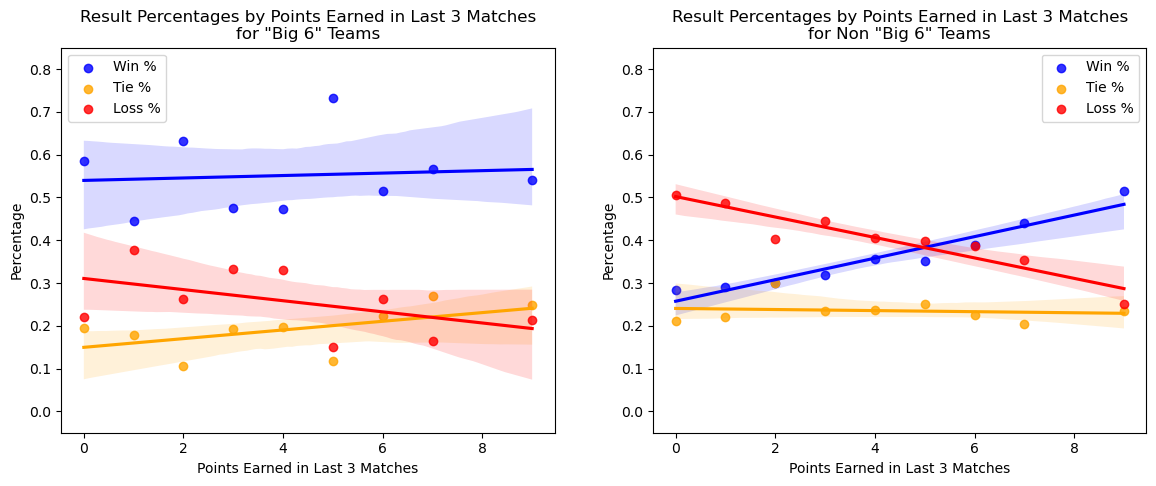

In [127]:
# Plotting regression line plots, no sample size needed because all of the groups have sample sizes much larger than 3
# Don't need 'masks' because all of the groups have a sample size > 2
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.regplot(x=big6_result_by_last3points.index, y=big6_result_by_last3points['WinPercentage'], color='blue', line_kws={'color': 'blue'}, label='Win %', ax=axes[0])
sns.regplot(x=big6_result_by_last3points.index, y=big6_result_by_last3points['TiePercentage'], color='orange', line_kws={'color': 'orange'}, label='Tie %', ax=axes[0])
sns.regplot(x=big6_result_by_last3points.index, y=big6_result_by_last3points['LossPercentage'], color='red', line_kws={'color': 'red'}, label='Loss %', ax=axes[0])
axes[0].set_xlabel("Points Earned in Last 3 Matches")
axes[0].set_ylabel("Percentage")
axes[0].set_title('Result Percentages by Points Earned in Last 3 Matches\nfor "Big 6" Teams')
axes[0].set_ylim(-.05,.85)
axes[0].legend()

sns.regplot(x=other_result_by_last3points.index, y=other_result_by_last3points['WinPercentage'], color='blue', line_kws={'color': 'blue'}, label='Win %', ax=axes[1])
sns.regplot(x=other_result_by_last3points.index, y=other_result_by_last3points['TiePercentage'], color='orange', line_kws={'color': 'orange'}, label='Tie %', ax=axes[1])
sns.regplot(x=other_result_by_last3points.index, y=other_result_by_last3points['LossPercentage'], color='red', line_kws={'color': 'red'}, label='Loss %', ax=axes[1])
axes[1].set_xlabel("Points Earned in Last 3 Matches")
axes[1].set_ylabel("Percentage")
axes[1].set_title('Result Percentages by Points Earned in Last 3 Matches\nfor Non "Big 6" Teams')
axes[1].set_ylim(-.05,.85)
axes[1].legend()

plt.show()

In [129]:
# calculating slope and r-value of linaer regression lines and putting in df to display
results = []
metric1 = 'PE in Last 3 Matches for "Big 6" Teams'
x1 = big6_result_by_last3points.index.values
reg_data1 = {'Win': big6_result_by_last3points['WinPercentage'].values, 'Tie': big6_result_by_last3points['TiePercentage'].values, 'Loss': big6_result_by_last3points['LossPercentage'].values}
for name, y1 in reg_data1.items():
    reg_line1 = linregress(x1, y1)
    results.append({'Metric': metric1,'Result': name,'Slope': reg_line1.slope, 'R-value': reg_line1.rvalue})

metric2 = 'PE in Last 3 Matches for Non "Big 6" Teams'
x2 = other_result_by_last3points.index.values
reg_data2 = {'Win': other_result_by_last3points['WinPercentage'].values, 'Tie': other_result_by_last3points['TiePercentage'].values, 'Loss': other_result_by_last3points['LossPercentage'].values}
for name, y2 in reg_data2.items():
    reg_line2 = linregress(x2, y2)
    results.append({'Metric': metric2,'Result': name,'Slope': reg_line2.slope, 'R-value': reg_line2.rvalue})

results_df = pd.DataFrame(results)
results_df

Metric Result     Slope   R-value
0      PE in Last 3 Matches for "Big 6" Teams    Win  0.002852  0.092361
1      PE in Last 3 Matches for "Big 6" Teams    Tie  0.010152  0.551094
2      PE in Last 3 Matches for "Big 6" Teams   Loss -0.013004 -0.487236
3  PE in Last 3 Matches for Non "Big 6" Teams    Win  0.025168  0.962893
4  PE in Last 3 Matches for Non "Big 6" Teams    Tie -0.001261 -0.133852
5  PE in Last 3 Matches for Non "Big 6" Teams   Loss -0.023907 -0.935146

There is a much stronger correlation between points earned in the last 3 matches and match outcome for non "big 6" teams than "big 6" teams with the exception of tie %.

### n = 5:

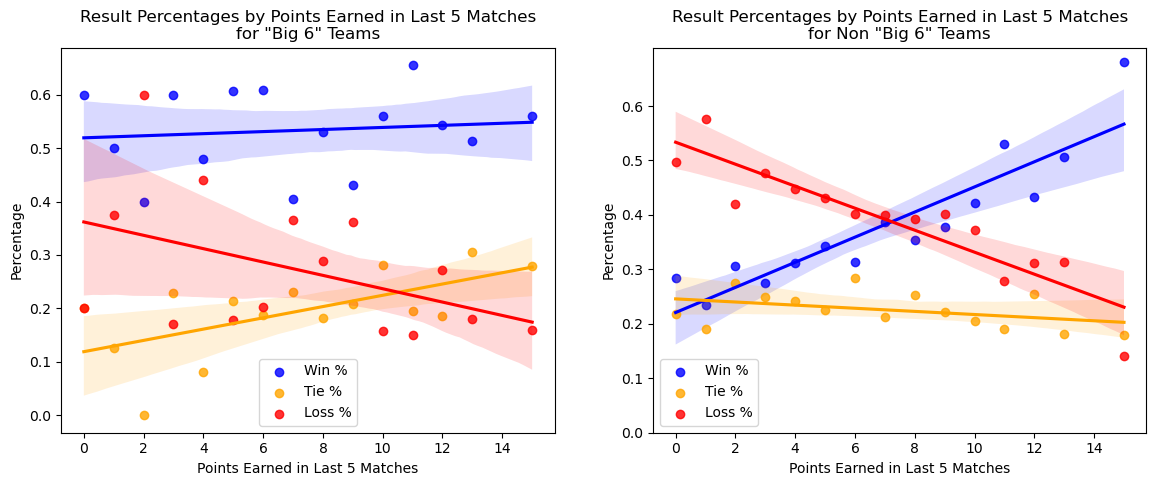

In [125]:
# Plotting regression line plots, no sample size needed because all of the groups have sample sizes much larger than 3
# Don't need 'masks' because all of the groups have a sample size > 2
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.regplot(x=big6_result_by_last5points.index, y=big6_result_by_last5points['WinPercentage'], color='blue', line_kws={'color': 'blue'}, label='Win %', ax=axes[0])
sns.regplot(x=big6_result_by_last5points.index, y=big6_result_by_last5points['TiePercentage'], color='orange', line_kws={'color': 'orange'}, label='Tie %', ax=axes[0])
sns.regplot(x=big6_result_by_last5points.index, y=big6_result_by_last5points['LossPercentage'], color='red', line_kws={'color': 'red'}, label='Loss %', ax=axes[0])
axes[0].set_xlabel("Points Earned in Last 5 Matches")
axes[0].set_ylabel("Percentage")
axes[0].set_title('Result Percentages by Points Earned in Last 5 Matches\nfor "Big 6" Teams')
axes[0].legend()

sns.regplot(x=other_result_by_last5points.index, y=other_result_by_last5points['WinPercentage'], color='blue', line_kws={'color': 'blue'}, label='Win %', ax=axes[1])
sns.regplot(x=other_result_by_last5points.index, y=other_result_by_last5points['TiePercentage'], color='orange', line_kws={'color': 'orange'}, label='Tie %', ax=axes[1])
sns.regplot(x=other_result_by_last5points.index, y=other_result_by_last5points['LossPercentage'], color='red', line_kws={'color': 'red'}, label='Loss %', ax=axes[1])
axes[1].set_xlabel("Points Earned in Last 5 Matches")
axes[1].set_ylabel("Percentage")
axes[1].set_title('Result Percentages by Points Earned in Last 5 Matches\nfor Non "Big 6" Teams')
axes[1].set_yticks([i/10 for i in range(0,7)])
axes[1].legend()

plt.show()

In [126]:
# calculating slope and r-value of linaer regression lines and putting in df to display
results = []
metric1 = 'PE in Last 5 Matches for "Big 6" Teams'
x1 = big6_result_by_last5points.index.values
reg_data1 = {'Win': big6_result_by_last5points['WinPercentage'].values, 'Tie': big6_result_by_last5points['TiePercentage'].values, 'Loss': big6_result_by_last5points['LossPercentage'].values}
for name, y1 in reg_data1.items():
    reg_line1 = linregress(x1, y1)
    results.append({'Metric': metric1,'Result': name,'Slope': reg_line1.slope,'R-value': reg_line1.rvalue})

metric2 = 'PE in Last 5 Matches for Non "Big 6" Teams'
x2 = other_result_by_last5points.index.values
reg_data2 = {'Win': other_result_by_last5points['WinPercentage'].values, 'Tie': other_result_by_last5points['TiePercentage'].values, 'Loss': other_result_by_last5points['LossPercentage'].values}
for name, y2 in reg_data2.items():
    reg_line2 = linregress(x2, y2)
    results.append({'Metric': metric2,'Result': name,'Slope': reg_line2.slope, 'R-value': reg_line2.rvalue})

results_df = pd.DataFrame(results)
results_df

Metric Result     Slope   R-value
0      PE in Last 5 Matches for "Big 6" Teams    Win  0.001945  0.114171
1      PE in Last 5 Matches for "Big 6" Teams    Tie  0.010556  0.617846
2      PE in Last 5 Matches for "Big 6" Teams   Loss -0.012500 -0.437494
3  PE in Last 5 Matches for Non "Big 6" Teams    Win  0.023065  0.906054
4  PE in Last 5 Matches for Non "Big 6" Teams    Tie -0.002871 -0.395295
5  PE in Last 5 Matches for Non "Big 6" Teams   Loss -0.020195 -0.904296

There is again a much stronger correlation between points earned in the last 3 matches and match outcome for non "big 6" teams than "big 6" teams with the exception of tie %.

### d) Using Goal Differential in the Last N Matches (n = 3 or 5) as the Momentum Metric

### n = 3:

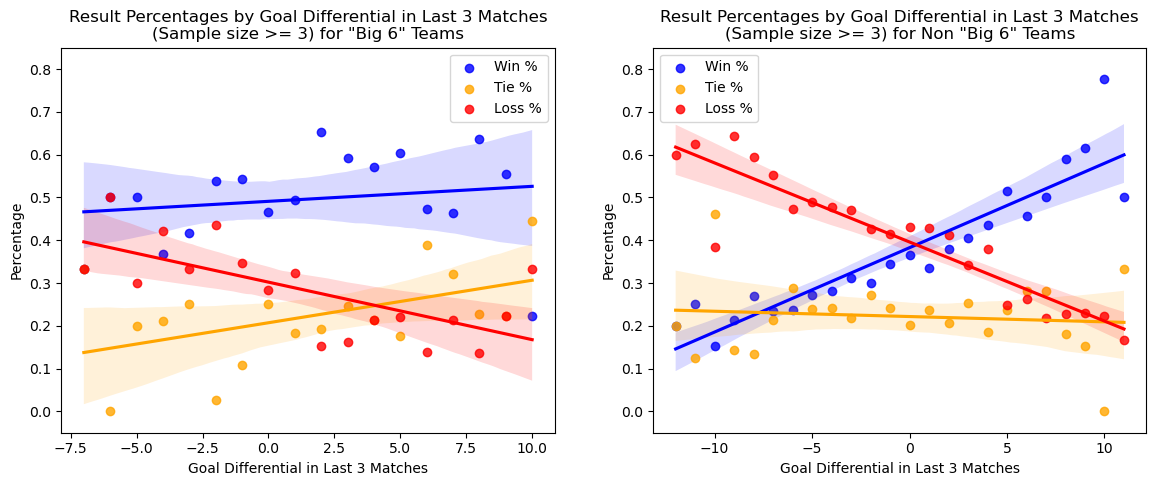

In [123]:
# Plotting regression line plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

big6_mask = big6_result_by_last3GD['SampleSize'] >= 3
big6_reduced_data = big6_result_by_last3GD[big6_mask]

sns.regplot(x=big6_reduced_data.index, y=big6_reduced_data['WinPercentage'], color='blue', line_kws={'color': 'blue'}, label='Win %', ax=axes[0])
sns.regplot(x=big6_reduced_data.index, y=big6_reduced_data['TiePercentage'], color='orange', line_kws={'color': 'orange'}, label='Tie %', ax=axes[0])
sns.regplot(x=big6_reduced_data.index, y=big6_reduced_data['LossPercentage'], color='red', line_kws={'color': 'red'}, label='Loss %', ax=axes[0])
axes[0].set_xlabel("Goal Differential in Last 3 Matches")
axes[0].set_ylabel("Percentage")
axes[0].set_title('Result Percentages by Goal Differential in Last 3 Matches\n(Sample size >= 3) for "Big 6" Teams')
axes[0].set_ylim(-.05, .85)
axes[0].legend()


other_mask = other_result_by_last3GD['SampleSize'] >= 3
other_reduced_data = other_result_by_last3GD[other_mask]

sns.regplot(x=other_reduced_data.index, y=other_reduced_data['WinPercentage'], color='blue', line_kws={'color': 'blue'}, label='Win %', ax=axes[1])
sns.regplot(x=other_reduced_data.index, y=other_reduced_data['TiePercentage'], color='orange', line_kws={'color': 'orange'}, label='Tie %', ax=axes[1])
sns.regplot(x=other_reduced_data.index, y=other_reduced_data['LossPercentage'], color='red', line_kws={'color': 'red'}, label='Loss %', ax=axes[1])
axes[1].set_xlabel("Goal Differential in Last 3 Matches")
axes[1].set_ylabel("Percentage")
axes[1].set_title('Result Percentages by Goal Differential in Last 3 Matches\n(Sample size >= 3) for Non "Big 6" Teams')
axes[1].set_ylim(-.05, .85)
axes[1].legend()

plt.show()

In [124]:
# calculating slope and r-value of linaer regression lines and putting in df to display
results = []
metric1 = 'GD in last 3 Matches for "Big 6 Teams'
x1 = big6_reduced_data.index.values
reg_data1 = {'Win': big6_reduced_data['WinPercentage'].values, 'Tie': big6_reduced_data['TiePercentage'].values, 'Loss': big6_reduced_data['LossPercentage'].values}
for name, y1 in reg_data1.items():
    reg_line1 = linregress(x1, y1)
    results.append({'Metric': metric1,'Result': name,'Slope': reg_line1.slope,'R-value': reg_line1.rvalue})

metric2 = 'GD in last 3 Matches for Non "Big 6 Teams"'
x2 = other_reduced_data.index.values
reg_data2 = {'Win': other_reduced_data['WinPercentage'].values, 'Tie': other_reduced_data['TiePercentage'].values, 'Loss': other_reduced_data['LossPercentage'].values}
for name, y2 in reg_data2.items():
    reg_line2 = linregress(x2, y2)
    results.append({'Metric': metric2,'Result': name,'Slope': reg_line2.slope, 'R-value': reg_line2.rvalue})

results_df = pd.DataFrame(results)
results_df

Metric Result     Slope   R-value
0       GD in last 3 Matches for "Big 6 Teams    Win  0.003507  0.170526
1       GD in last 3 Matches for "Big 6 Teams    Tie  0.009940  0.480087
2       GD in last 3 Matches for "Big 6 Teams   Loss -0.013447 -0.672089
3  GD in last 3 Matches for Non "Big 6 Teams"    Win  0.019722  0.917579
4  GD in last 3 Matches for Non "Big 6 Teams"    Tie -0.001238 -0.102536
5  GD in last 3 Matches for Non "Big 6 Teams"   Loss -0.018484 -0.923272

Again there is a much stronger correlation between points earned in the last 3 matches and match outcome for non "big 6" teams than "big 6" teams with the exception of tie %.

### n = 5:

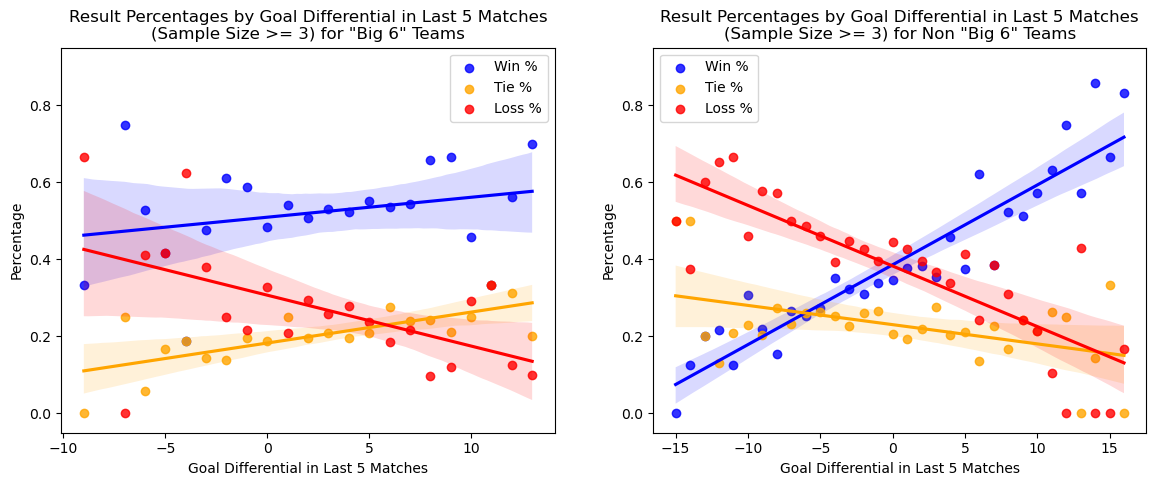

In [121]:
# Plotting regression line plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

big6_mask = big6_result_by_last5GD['SampleSize'] >= 3
big6_reduced_data = big6_result_by_last5GD[big6_mask]

sns.regplot(x=big6_reduced_data.index, y=big6_reduced_data['WinPercentage'], color='blue', line_kws={'color': 'blue'}, label='Win %', ax=axes[0])
sns.regplot(x=big6_reduced_data.index, y=big6_reduced_data['TiePercentage'], color='orange', line_kws={'color': 'orange'}, label='Tie %', ax=axes[0])
sns.regplot(x=big6_reduced_data.index, y=big6_reduced_data['LossPercentage'], color='red', line_kws={'color': 'red'}, label='Loss %', ax=axes[0])
axes[0].set_xlabel("Goal Differential in Last 5 Matches")
axes[0].set_ylabel("Percentage")
axes[0].set_title('Result Percentages by Goal Differential in Last 5 Matches\n(Sample Size >= 3) for "Big 6" Teams')
axes[0].set_ylim(-.05,.95)
axes[0].legend()


other_mask = other_result_by_last5GD['SampleSize'] >= 3
other_reduced_data = other_result_by_last5GD[other_mask]

sns.regplot(x=other_reduced_data.index, y=other_reduced_data['WinPercentage'], color='blue', line_kws={'color': 'blue'}, label='Win %', ax=axes[1])
sns.regplot(x=other_reduced_data.index, y=other_reduced_data['TiePercentage'], color='orange', line_kws={'color': 'orange'}, label='Tie %', ax=axes[1])
sns.regplot(x=other_reduced_data.index, y=other_reduced_data['LossPercentage'], color='red', line_kws={'color': 'red'}, label='Loss %', ax=axes[1])
axes[1].set_xlabel("Goal Differential in Last 5 Matches")
axes[1].set_ylabel("Percentage")
axes[1].set_title('Result Percentages by Goal Differential in Last 5 Matches\n(Sample Size >= 3) for Non "Big 6" Teams')
axes[1].set_ylim(-.05,.95)
axes[1].legend()

plt.show()

In [122]:
# calculating slope and r-value of linaer regression lines and putting in df to display
results = []
metric1 = 'GD in last 5 Matches for "Big 6 Teams'
x1 = big6_reduced_data.index.values
reg_data1 = {'Win': big6_reduced_data['WinPercentage'].values, 'Tie': big6_reduced_data['TiePercentage'].values, 'Loss': big6_reduced_data['LossPercentage'].values}
for name, y1 in reg_data1.items():
    reg_line1 = linregress(x1, y1)
    results.append({'Metric': metric1,'Result': name,'Slope': reg_line1.slope, 'R-value': reg_line1.rvalue})

metric2 = 'GD in last 5 Matches for Non "Big 6 Teams"'
x2 = other_reduced_data.index.values
reg_data2 = {'Win': other_reduced_data['WinPercentage'].values, 'Tie': other_reduced_data['TiePercentage'].values, 'Loss': other_reduced_data['LossPercentage'].values}
for name, y2 in reg_data2.items():
    reg_line2 = linregress(x2, y2)
    results.append({'Metric': metric2,'Result': name,'Slope': reg_line2.slope, 'R-value': reg_line2.rvalue})

results_df = pd.DataFrame(results)
results_df

Metric Result     Slope   R-value
0       GD in last 5 Matches for "Big 6 Teams    Win  0.005177  0.267033
1       GD in last 5 Matches for "Big 6 Teams    Tie  0.008033  0.710462
2       GD in last 5 Matches for "Big 6 Teams   Loss -0.013210 -0.542492
3  GD in last 5 Matches for Non "Big 6 Teams"    Win  0.020723  0.931214
4  GD in last 5 Matches for Non "Big 6 Teams"    Tie -0.004994 -0.469442
5  GD in last 5 Matches for Non "Big 6 Teams"   Loss -0.015729 -0.830830

Again we get the same result: the correlation between goal differential in last 5 matches and match outcome is stronger for non "big 6" teams than "big 6" teams, with the exception of tie %.

# Q9. Does negative momentum correlate with match outcome?

### We will use loss streaks and games since win as negative momentum

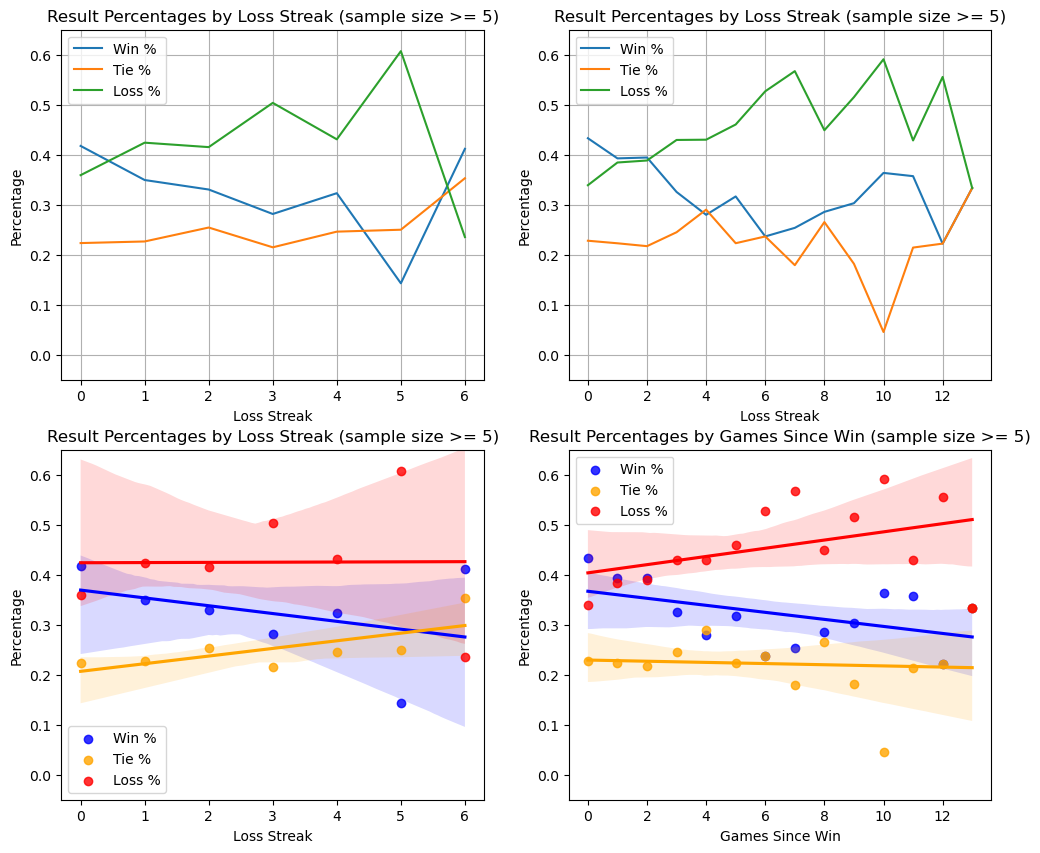

In [307]:
# Plotting line charts and regression line plots for loss streak and games since win; requiring original minimum sample size of 5
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

samplesize_mask = result_by_lossstreak['SampleSize'] >= 5
lossstreak_reduced_data = result_by_lossstreak[samplesize_mask]

axes[0,0].plot(lossstreak_reduced_data.index, lossstreak_reduced_data['WinPercentage'], label='Win %')
axes[0,0].plot(lossstreak_reduced_data.index, lossstreak_reduced_data['TiePercentage'], label='Tie %')
axes[0,0].plot(lossstreak_reduced_data.index, lossstreak_reduced_data['LossPercentage'], label='Loss %')
axes[0,0].set_xlabel("Loss Streak")
axes[0,0].set_ylabel("Percentage")
axes[0,0].set_title("Result Percentages by Loss Streak (sample size >= 5)")
axes[0,0].grid(True)
axes[0,0].legend()
axes[0,0].set_ylim(-.05,.65)

samplesize_mask = result_by_gamessincewin['SampleSize'] >= 5
gamessincewin_reduced_data = result_by_gamessincewin[samplesize_mask]

axes[0,1].plot(gamessincewin_reduced_data.index, gamessincewin_reduced_data['WinPercentage'], label='Win %')
axes[0,1].plot(gamessincewin_reduced_data.index, gamessincewin_reduced_data['TiePercentage'], label='Tie %')
axes[0,1].plot(gamessincewin_reduced_data.index, gamessincewin_reduced_data['LossPercentage'], label='Loss %')
axes[0,1].set_xlabel("Loss Streak")
axes[0,1].set_ylabel("Percentage")
axes[0,1].set_title("Result Percentages by Loss Streak (sample size >= 5)")
axes[0,1].grid(True)
axes[0,1].legend()
axes[0,1].set_ylim(-.05,.65)

sns.regplot(x=lossstreak_reduced_data.index, y=lossstreak_reduced_data['WinPercentage'], color='blue', line_kws={'color': 'blue'}, label='Win %', ax=axes[1,0])
sns.regplot(x=lossstreak_reduced_data.index, y=lossstreak_reduced_data['TiePercentage'], color='orange', line_kws={'color': 'orange'}, label='Tie %', ax=axes[1,0])
sns.regplot(x=lossstreak_reduced_data.index, y=lossstreak_reduced_data['LossPercentage'], color='red', line_kws={'color': 'red'}, label='Loss %', ax=axes[1,0])
axes[1,0].set_xlabel("Loss Streak")
axes[1,0].set_ylabel("Percentage")
axes[1,0].set_title('Result Percentages by Loss Streak (sample size >= 5)')
axes[1,0].set_ylim(-.05, .65)
axes[1,0].legend()

sns.regplot(x=gamessincewin_reduced_data.index, y=gamessincewin_reduced_data['WinPercentage'], color='blue', line_kws={'color': 'blue'}, label='Win %', ax=axes[1,1])
sns.regplot(x=gamessincewin_reduced_data.index, y=gamessincewin_reduced_data['TiePercentage'], color='orange', line_kws={'color': 'orange'}, label='Tie %', ax=axes[1,1])
sns.regplot(x=gamessincewin_reduced_data.index, y=gamessincewin_reduced_data['LossPercentage'], color='red', line_kws={'color': 'red'}, label='Loss %', ax=axes[1,1])
axes[1,1].set_xlabel("Games Since Win")
axes[1,1].set_ylabel("Percentage")
axes[1,1].set_title('Result Percentages by Games Since Win (sample size >= 5)')
axes[1,1].set_ylim(-.05, .65)
axes[1,1].legend()

In [308]:
# calculating slope and r-value of linaer regression lines and putting in df to display
results = []

metric1 = 'Loss Streak (Sample Size >= 5)'
x1 = lossstreak_reduced_data.index.values
reg_data1 = {'Win': lossstreak_reduced_data['WinPercentage'].values, 'Tie': lossstreak_reduced_data['TiePercentage'].values, 'Loss': lossstreak_reduced_data['LossPercentage'].values}
for name, y1 in reg_data1.items():
    reg_line1 = linregress(x1, y1)
    results.append({'Metric': metric1,'Result': name,'Slope': reg_line1.slope,'R-value': reg_line1.rvalue})

metric2 = 'Games Since Win (Sample Size >= 5)'
x2 = gamessincewin_reduced_data.index.values
reg_data2 = {'Win': gamessincewin_reduced_data['WinPercentage'].values, 'Tie': gamessincewin_reduced_data['TiePercentage'].values, 'Loss': gamessincewin_reduced_data['LossPercentage'].values}
for name, y2 in reg_data2.items():
    reg_line2 = linregress(x2, y2)
    results.append({'Metric': metric2,'Result': name,'Slope': reg_line2.slope,'R-value': reg_line2.rvalue})

results_df = pd.DataFrame(results)
results_df

Metric Result     Slope   R-value
0      Loss Streak (Sample Size >= 5)    Win -0.015638 -0.363748
1      Loss Streak (Sample Size >= 5)    Tie  0.015275  0.706523
2      Loss Streak (Sample Size >= 5)   Loss  0.000363  0.006798
3  Games Since Win (Sample Size >= 5)    Win -0.007029 -0.469180
4  Games Since Win (Sample Size >= 5)    Tie -0.001170 -0.075645
5  Games Since Win (Sample Size >= 5)   Loss  0.008199  0.413166

We see a slight correlation betwen match negative momentum and match results. Although these correlations are much weaker than all of the positive momentum metrics. The strongest correlation is between loss streak and tie %. This is interesting because all of the momentum metrics got much weaker correlation with tie % then win % or loss %.

# Q9. Does home/away change the affect of momentum?

In [98]:
# Creating dataframe of results by different momentum metrics that include home and away match results to do analysis
def create_new_df_with_sides(metric):
    groups = df.groupby(metric)
    group_counts = groups.size()
    curr_df = group_counts.to_frame() # Transforming series of win streak counts to dataframe
    curr_df.columns = ['SampleSize'] # Naming column
    # Adding match result percentages by metric by home/away
    curr_df['HomeWinPercentage'] = df[df['Home/Away']=='Home'].groupby(metric)['Result'].apply(lambda x: (x=='W').mean())
    curr_df['AwayWinPercentage'] = df[df['Home/Away']=='Away'].groupby(metric)['Result'].apply(lambda x: (x=='W').mean())
    curr_df['HomeTiePercentage'] = df[df['Home/Away']=='Home'].groupby(metric)['Result'].apply(lambda x: (x=='T').mean())
    curr_df['AwayTiePercentage'] = df[df['Home/Away']=='Away'].groupby(metric)['Result'].apply(lambda x: (x=='T').mean())
    curr_df['HomeLossPercentage'] = df[df['Home/Away']=='Home'].groupby(metric)['Result'].apply(lambda x: (x=='L').mean())
    curr_df['AwayLossPercentage'] = df[df['Home/Away']=='Away'].groupby(metric)['Result'].apply(lambda x: (x=='L').mean())

    return curr_df

result_by_winstreak_with_sides = create_new_df_with_sides('WinStreakBefore')
result_by_unbeatenstreak_with_sides = create_new_df_with_sides('UnbeatenStreakBefore')
result_by_last3points_with_sides = create_new_df_with_sides('Last3Points')
result_by_last5points_with_sides = create_new_df_with_sides('Last5Points')
result_by_last3GD_with_sides = create_new_df_with_sides('Last3GD')
result_by_last5GD_with_sides = create_new_df_with_sides('Last5GD')
result_by_lossstreak_with_sides = create_new_df_with_sides('LossStreakBefore')
result_by_gamessincewin_with_sides = create_new_df_with_sides('GamesSinceWin')

In [99]:
# Example of what these dataframes look like
result_by_winstreak_with_sides

SampleSize  HomeWinPercentage  AwayWinPercentage  \
WinStreakBefore                                                     
0                      2378           0.398714           0.313051   
1                       827           0.452381           0.338530   
2                       315           0.507042           0.427746   
3                       140           0.523077           0.440000   
4                        65           0.562500           0.424242   
5                        29           0.823529           0.166667   
6                        15           0.500000           0.571429   
7                         8           0.666667           0.800000   
8                         6           1.000000           0.666667   
9                         4           1.000000           1.000000   
10                        4           1.000000           0.666667   
11                        3           1.000000           1.000000   
12                        3                NaN           0.333333   
13                        1           1.000000                NaN   
14                        1           1.000000                NaN   
15                        1           0.000000                NaN   

                 HomeTiePercentage  AwayTiePercentage  HomeLossPercentage  \
WinStreakBefore                                                             
0                         0.231511           0.216049            0.369775   
1                         0.246032           0.227171            0.301587   
2                         0.190141           0.254335            0.302817   
3                         0.230769           0.293333            0.246154   
4                         0.156250           0.272727            0.281250   
5                         0.058824           0.416667            0.117647   
6                         0.375000           0.142857            0.125000   
7                         0.333333           0.200000            0.000000   
8                         0.000000           0.333333            0.000000   
9                         0.000000           0.000000            0.000000   
10                        0.000000           0.333333            0.000000   
11                        0.000000           0.000000            0.000000   
12                             NaN           0.666667                 NaN   
13                        0.000000                NaN            0.000000   
14                        0.000000                NaN            0.000000   
15                        0.000000                NaN            1.000000   

                 AwayLossPercentage  
WinStreakBefore                      
0                          0.470899  
1                          0.434298  
2                          0.317919  
3                          0.266667  
4                          0.303030  
5                          0.416667  
6                          0.285714  
7                          0.000000  
8                          0.000000  
9                          0.000000  
10                         0.000000  
11                         0.000000  
12                         0.000000  
13                              NaN  
14                              NaN  
15                              NaN

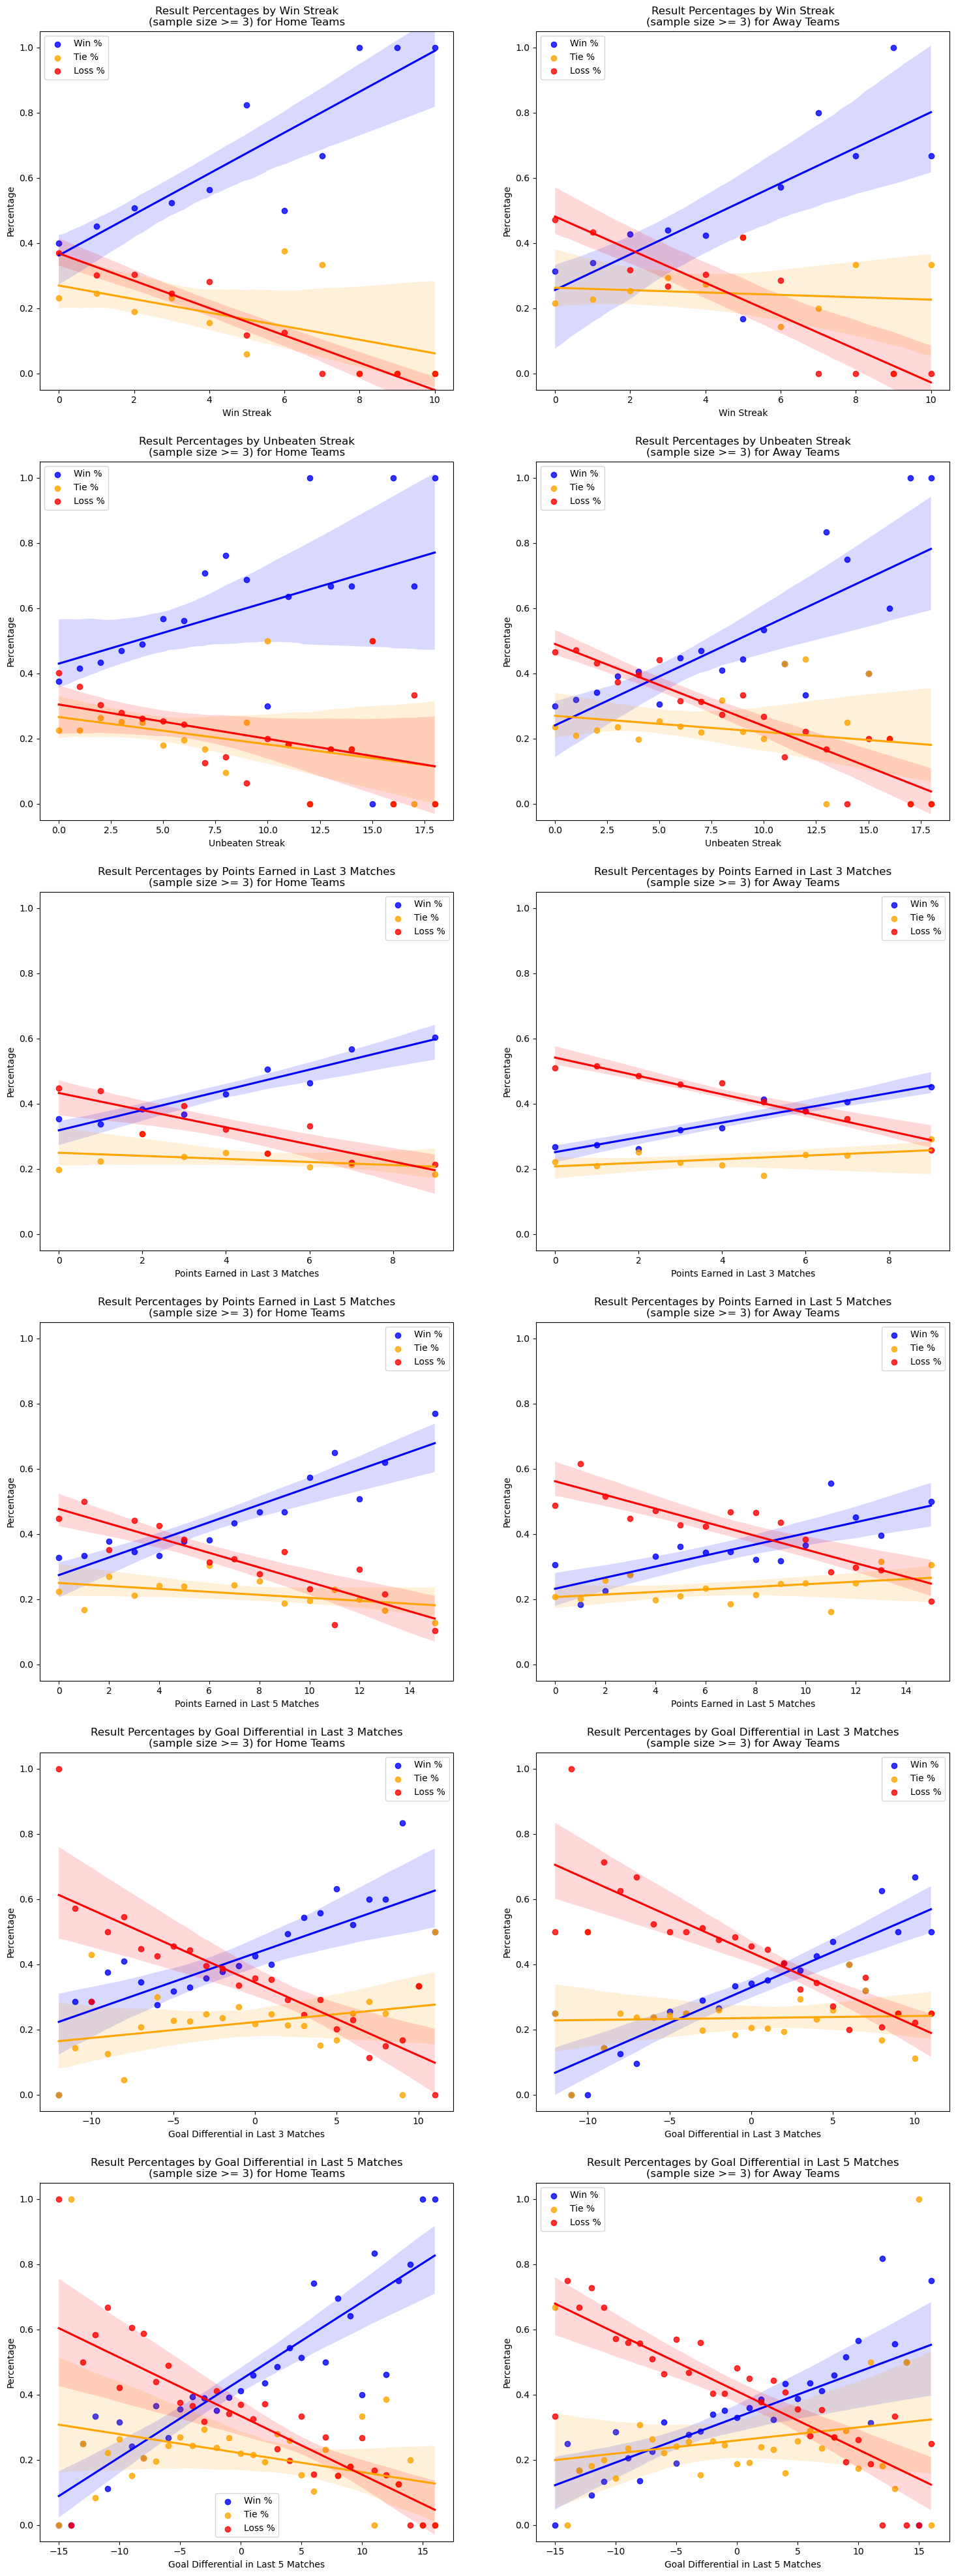

In [361]:
# Plotting regression line plots
fig, axes = plt.subplots(6, 2, figsize=(18,50))

momentum_metrics = {'Win Streak': result_by_winstreak_with_sides, 'Unbeaten Streak': result_by_unbeatenstreak_with_sides, 'Points Earned in Last 3 Matches': result_by_last3points_with_sides,
          'Points Earned in Last 5 Matches': result_by_last5points_with_sides, 'Goal Differential in Last 3 Matches': result_by_last3GD_with_sides, 
          'Goal Differential in Last 5 Matches': result_by_last5GD_with_sides}

i = 0
for name, curr_metric_df in momentum_metrics.items():
    mask = curr_metric_df['SampleSize'] >= 4 # we are dropping the minimum sample size from 5 to 4 because now the results are broken in half (if it is 3 then win streak does not have any home results)
    reduced_data = curr_metric_df[mask]
    
    sns.regplot(x=reduced_data.index, y=reduced_data['HomeWinPercentage'], color='blue', line_kws={'color': 'blue'}, label='Win %', ax=axes[i,0])
    sns.regplot(x=reduced_data.index, y=reduced_data['HomeTiePercentage'], color='orange', line_kws={'color': 'orange'}, label='Tie %', ax=axes[i,0])
    sns.regplot(x=reduced_data.index, y=reduced_data['HomeLossPercentage'], color='red', line_kws={'color': 'red'}, label='Loss %', ax=axes[i,0])
    axes[i,0].set_xlabel(name)
    axes[i,0].set_ylabel("Percentage")
    axes[i,0].set_ylim(-.05, 1.05)
    axes[i,0].set_title(f'Result Percentages by {name}\n(sample size >= 3) for Home Teams')
    axes[i,0].legend()

    sns.regplot(x=reduced_data.index, y=reduced_data['AwayWinPercentage'], color='blue', line_kws={'color': 'blue'}, label='Win %', ax=axes[i,1])
    sns.regplot(x=reduced_data.index, y=reduced_data['AwayTiePercentage'], color='orange', line_kws={'color': 'orange'}, label='Tie %', ax=axes[i,1])
    sns.regplot(x=reduced_data.index, y=reduced_data['AwayLossPercentage'], color='red', line_kws={'color': 'red'}, label='Loss %', ax=axes[i,1])
    axes[i,1].set_xlabel(name)
    axes[i,1].set_ylabel("Percentage")
    axes[i,1].set_ylim(-.05, 1.05)
    axes[i,1].set_title(f'Result Percentages by {name}\n(sample size >= 3) for Away Teams')
    axes[i,1].legend()

    i += 1
    
plt.show()

In [117]:
results = []
for name, curr_metric_df in momentum_metrics.items():
    mask = curr_metric_df['SampleSize'] >= 4
    reduced_data = curr_metric_df[mask]

    x = reduced_data.index.values
    reg_data = {'Home Win': reduced_data['HomeWinPercentage'].values, 'Home Tie': reduced_data['HomeTiePercentage'].values,
                'Home Loss': reduced_data['HomeLossPercentage'].values, 'Away Win': reduced_data['AwayWinPercentage'].values, 
                'Away Tie': reduced_data['AwayTiePercentage'].values, 'Away Loss': reduced_data['AwayLossPercentage'].values,}
    for result, y in reg_data.items():
        reg_line = linregress(x, y)
        rvalue = reg_line.rvalue
        results.append({'Metric': name, 'Result': result,'Slope': reg_line.slope, 'R-value': reg_line.rvalue}) 

results_df = pd.DataFrame(results)
results_df

Metric     Result     Slope   R-value
0                            Win Streak   Home Win  0.062731  0.879622
1                            Win Streak   Home Tie -0.020802 -0.512246
2                            Win Streak  Home Loss -0.041929 -0.955165
3                            Win Streak   Away Win  0.054526  0.751995
4                            Win Streak   Away Tie -0.003653 -0.109727
5                            Win Streak  Away Loss -0.050874 -0.884845
6                       Unbeaten Streak   Home Win  0.018929  0.424185
7                       Unbeaten Streak   Home Tie -0.008400 -0.331439
8                       Unbeaten Streak  Home Loss -0.010529 -0.426232
9                       Unbeaten Streak   Away Win  0.030073  0.758174
10                      Unbeaten Streak   Away Tie -0.004952 -0.221513
11                      Unbeaten Streak  Away Loss -0.025121 -0.919739
12      Points Earned in Last 3 Matches   Home Win  0.031029  0.950098
13      Points Earned in Last 3 Matches   Home Tie -0.004719 -0.373348
14      Points Earned in Last 3 Matches  Home Loss -0.026311 -0.870652
15      Points Earned in Last 3 Matches   Away Win  0.022654  0.943601
16      Points Earned in Last 3 Matches   Away Tie  0.005501  0.509372
17      Points Earned in Last 3 Matches  Away Loss -0.028154 -0.971263
18      Points Earned in Last 5 Matches   Home Win  0.026977  0.918440
19      Points Earned in Last 5 Matches   Home Tie -0.004552 -0.461665
20      Points Earned in Last 5 Matches  Home Loss -0.022425 -0.887139
21      Points Earned in Last 5 Matches   Away Win  0.017007  0.807949
22      Points Earned in Last 5 Matches   Away Tie  0.003923  0.412406
23      Points Earned in Last 5 Matches  Away Loss -0.020930 -0.892848
24  Goal Differential in Last 3 Matches   Home Win  0.017500  0.759467
25  Goal Differential in Last 3 Matches   Home Tie  0.004866  0.300421
26  Goal Differential in Last 3 Matches  Home Loss -0.022366 -0.808166
27  Goal Differential in Last 3 Matches   Away Win  0.021809  0.897252
28  Goal Differential in Last 3 Matches   Away Tie  0.000610  0.046054
29  Goal Differential in Last 3 Matches  Away Loss -0.022420 -0.853647
30  Goal Differential in Last 5 Matches   Home Win  0.023795  0.894811
31  Goal Differential in Last 5 Matches   Home Tie -0.005827 -0.317308
32  Goal Differential in Last 5 Matches  Home Loss -0.017968 -0.763430
33  Goal Differential in Last 5 Matches   Away Win  0.013888  0.700051
34  Goal Differential in Last 5 Matches   Away Tie  0.004016  0.202688
35  Goal Differential in Last 5 Matches  Away Loss -0.017904 -0.856155
36                          Loss Streak   Home Win -0.008892 -0.178472
37                          Loss Streak   Home Tie  0.006256  0.354130
38                          Loss Streak  Home Loss  0.002636  0.046572
39                          Loss Streak   Away Win -0.027105 -0.640445
40                          Loss Streak   Away Tie  0.027020  0.818714
41                          Loss Streak  Away Loss  0.000085  0.001672
42                      Games Since Win   Home Win -0.009103 -0.381340
43                      Games Since Win   Home Tie -0.001092 -0.044482
44                      Games Since Win  Home Loss  0.010196  0.379916
45                      Games Since Win   Away Win -0.002059 -0.096138
46                      Games Since Win   Away Tie  0.001044  0.035816
47                      Games Since Win  Away Loss  0.001014  0.025113

Looking through the r-values, there does not seem to be a change in the effect of momentum if a team is playing at home or away. WEther their is a stronger correlation between home result or away result depends on the momentum metric.

# Q10. What Momentum Metric is the Best Indicator of Match Outcome?

### We have looked at the following momentum metrics: win streak, unbeaten streak, points earned in the last 3 games, points earned in the last 5 games, goal differential in the last 3 games, goal differential in the last 5 games, loss streak (negative) , and games since win (negative)

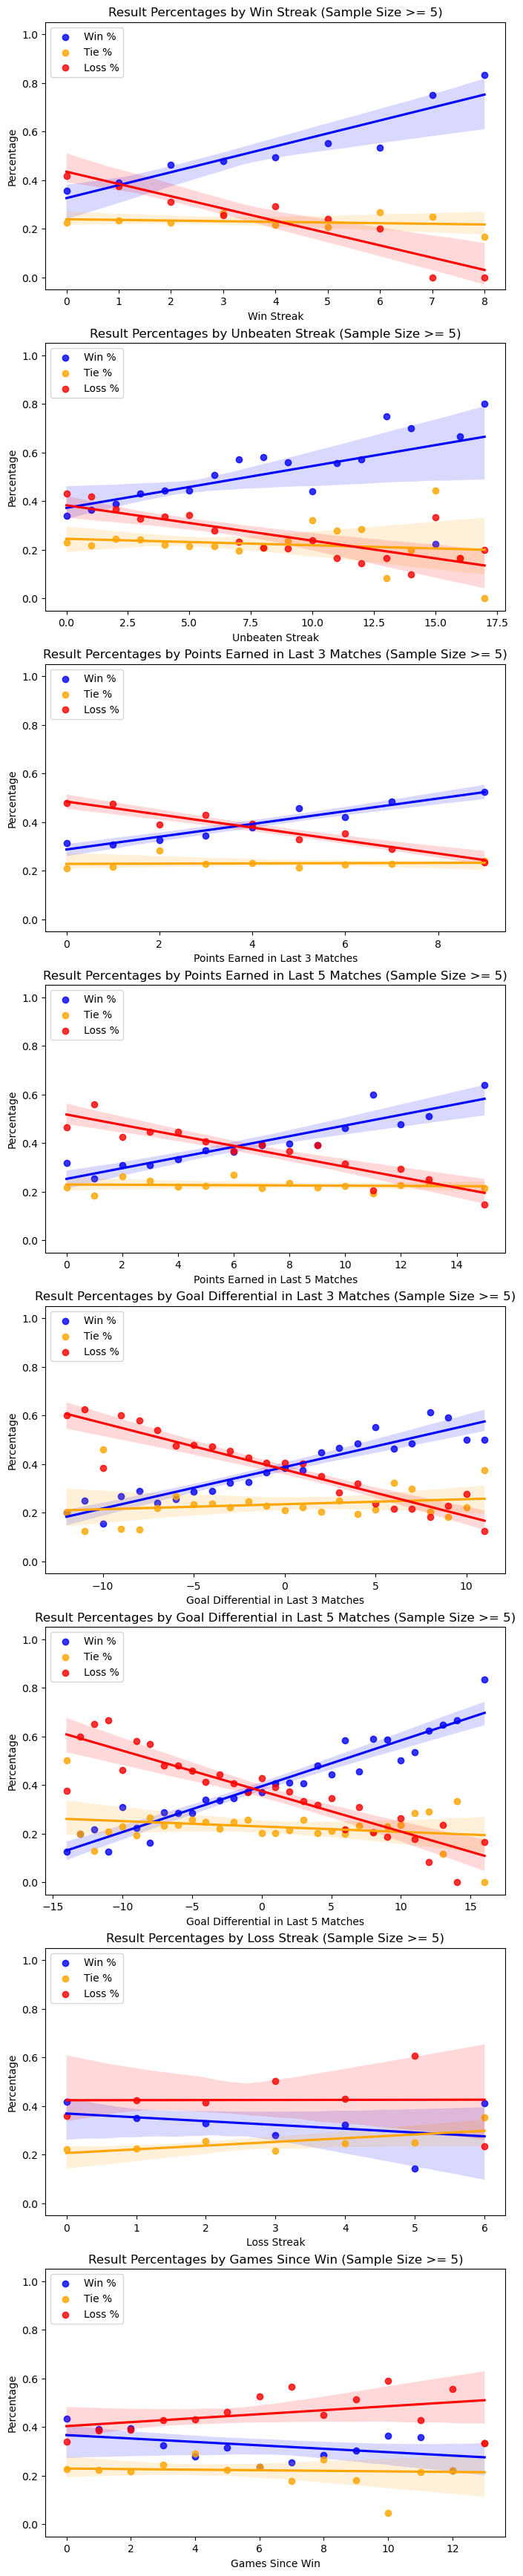

In [334]:
# Plotting regression line plots
fig, axes = plt.subplots(8, 1, figsize=(8,44))

momentum_metrics = {'Win Streak': result_by_winstreak, 'Unbeaten Streak': result_by_unbeatenstreak, 'Points Earned in Last 3 Matches': result_by_last3points,
          'Points Earned in Last 5 Matches': result_by_last5points, 'Goal Differential in Last 3 Matches': result_by_last3GD, 
          'Goal Differential in Last 5 Matches': result_by_last5GD, 'Loss Streak': result_by_lossstreak, 'Games Since Win': result_by_gamessincewin}

i = 0
for name, curr_metric_df in momentum_metrics.items():
    mask = curr_metric_df['SampleSize'] >= 5
    reduced_data = curr_metric_df[mask]
    
    sns.regplot(x=reduced_data.index, y=reduced_data['WinPercentage'], color='blue', line_kws={'color': 'blue'}, label='Win %', ax=axes[i])
    sns.regplot(x=reduced_data.index, y=reduced_data['TiePercentage'], color='orange', line_kws={'color': 'orange'}, label='Tie %', ax=axes[i]) 
    sns.regplot(x=reduced_data.index, y=reduced_data['LossPercentage'], color='red', line_kws={'color': 'red'}, label='Loss %', ax=axes[i])
    axes[i].set_xlabel(name)
    axes[i].set_ylabel("Percentage")
    axes[i].set_ylim(-.05, 1.05)
    axes[i].set_title(f'Result Percentages by {name} (Sample Size >= 5)')
    axes[i].legend(loc = 'upper left')

    i += 1
    
plt.show()

In [162]:
results = []
for name, curr_metric_df in momentum_metrics.items():
    mask = curr_metric_df['SampleSize'] > 4
    reduced_data = curr_metric_df[mask]

    x = reduced_data.index.values
    reg_data = {'Win': reduced_data['WinPercentage'].values, 'Tie': reduced_data['TiePercentage'].values, 'Loss': reduced_data['LossPercentage'].values}
    for result, y in reg_data.items():
        reg_line = linregress(x, y)
        results.append({'Metric': name, 'Result': result,'Slope': reg_line.slope, 'R-value': reg_line.rvalue}) 

results_df = pd.DataFrame(results)
results_df


Metric Result     Slope   R-value
0                            Win Streak    Win  0.053217  0.927035
1                            Win Streak    Tie -0.002702 -0.237833
2                            Win Streak   Loss -0.050515 -0.938197
3                       Unbeaten Streak    Win  0.017209  0.609233
4                       Unbeaten Streak    Tie -0.002649 -0.155587
5                       Unbeaten Streak   Loss -0.014560 -0.790248
6       Points Earned in Last 3 Matches    Win  0.026221  0.959847
7       Points Earned in Last 3 Matches    Tie  0.000491  0.066122
8       Points Earned in Last 3 Matches   Loss -0.026712 -0.957717
9       Points Earned in Last 5 Matches    Win  0.021969  0.916025
10      Points Earned in Last 5 Matches    Tie -0.000471 -0.095674
11      Points Earned in Last 5 Matches   Loss -0.021498 -0.919356
12  Goal Differential in Last 3 Matches    Win  0.017046  0.940836
13  Goal Differential in Last 3 Matches    Tie  0.002065  0.196690
14  Goal Differential in Last 3 Matches   Loss -0.019111 -0.931092
15  Goal Differential in Last 5 Matches    Win  0.018871  0.956446
16  Goal Differential in Last 5 Matches    Tie -0.002222 -0.251779
17  Goal Differential in Last 5 Matches   Loss -0.016648 -0.901554
18                          Loss Streak    Win -0.015638 -0.363748
19                          Loss Streak    Tie  0.015275  0.706523
20                          Loss Streak   Loss  0.000363  0.006798
21                      Games Since Win    Win -0.007029 -0.469180
22                      Games Since Win    Tie -0.001170 -0.075645
23                      Games Since Win   Loss  0.008199  0.413166

In [201]:
max_win_rvalue = results_df[results_df['Result'] == 'Win']['R-value'].max()
max_win_metric = results_df[results_df['R-value'] == max_win_rvalue]['Metric']
max_tie_rvalue = abs(results_df[results_df['Result'] == 'Tie']['R-value']).max()
max_tie_metric = results_df[results_df['R-value'] == max_tie_rvalue]['Metric']
max_loss_rvalue = results_df[results_df['Result'] == 'Loss']['R-value'].min() # we see that the strongest loss % correlations are negative so finding min
max_loss_metric = results_df[results_df['R-value'] == max_loss_rvalue]['Metric']

In [203]:
print(f'Max Win R-value: {max_win_rvalue}')
print(f'Strongest Win Correlation Metric: {max_win_metric}')
print(f'Max Tie R-value: {max_tie_rvalue}')
print(f'Strongest Tie Correlation Metric: {max_tie_metric}')
print(f'Max R-value: {max_loss_rvalue}')
print(f'Strongest Loss Correlation Metric: {max_loss_metric}')

Max Win R-value: 0.9598467196688868
Strongest Win Correlation Metric: 6    Points Earned in Last 3 Matches
Name: Metric, dtype: object
Max Tie R-value: 0.7065231036911638
Strongest Tie Correlation Metric: 19    Loss Streak
Name: Metric, dtype: object
Max R-value: -0.9577170782936103
Strongest Loss Correlation Metric: 8    Points Earned in Last 3 Matches
Name: Metric, dtype: object


We see that the strongest win % correlation was .960 with points earned in the last 3 matches (although goal differential in last 5 matches is a close second). Strongest tie % correlation was just was .707 with loss streak (this was by far the strongest correlation). Strong loss % correlation is -.958 with points earned in last 3 matches. Overall, points earned in the last 3 matches has the strongest correlation with match outcome. We can also conclude that there are much stronger correlations with momentum metrics and winn % and loss % than tie %.

# Q11. Which teams have the biggest swings in form? / Which teams exhibit the highest overall volatility in form across the last five seasons?

#### Notes: big swings in form - going from winning streak to losing streak (the longer those streaks the larger the swing in form) - basically teams that are inconsistent. Team with no swings is consistent (either good, bad, or mediocre)
#### These swings can be measured by looking at the Standard deviation of GD per match for a team - this will tell us if a team has a high standard deviation - their match results are volatile and low std = pretty consistent.
#### We can also look at the standard deviation of points per match and then streak volatility

In [204]:
# teams in specific seasons - need to average out all 5 seasons for each team
team_season_swings = (df.groupby(['Team', 'Season'])['GoalDifferential'].agg(['mean','std','min','max','count']).rename(columns={'std': 'GD_StdDev'}).sort_values('GD_StdDev', ascending=False))

In [205]:
team_season_swings.head()

mean  GD_StdDev  min  max  count
Team        Season                                         
Newcastle   2023-2024  0.605263   2.444403   -3    8     38
Liverpool   2022-2023  0.736842   2.378782   -3    9     38
Aston Villa 2023-2024  0.394737   2.296172   -5    5     38
Bournemouth 2022-2023 -0.894737   2.227463   -9    3     38
Southampton 2020-2021 -0.552632   2.189624   -9    3     38

In [392]:
def analyze_team_season_swings(group, n_win=3, n_loss=3): #n_win and n_loss are number of games we considered streaks
    # Sort by week to ensure chronological order
    group = group.sort_values(['Season', 'WeekNumber']) 
    
    results = group['Result'].values  
    
    curr_win = 0
    curr_loss = 0
    max_win = 0
    max_loss = 0
    
    has_big_win_streak = False # this is a boolean that tells us if a team currently has a win streak
    has_big_loss_streak = False # this is a boolean that tells us if a team currently has a win streak
    has_big_loss_after_big_win = False # this is a boolean that tells us that a team has a loss streak after a win streak
    has_big_win_after_big_loss = False # this is a boolean that tells us that a team has a win streak after a loss streak
    
    for r in results: # tracking results to find streaks
        if r == 'W':
            curr_win += 1
            curr_loss = 0
        elif r == 'L':
            curr_loss += 1
            curr_win = 0
        else:  
            curr_win = 0
            curr_loss = 0
        
        # Track max streaks
        if curr_win > max_win:
            max_win = curr_win
        if curr_loss > max_loss:
            max_loss = curr_loss
        
        
        if max_win >= n_win:
            has_big_win_streak = True
        
        
        if has_big_win_streak and curr_loss >= n_loss:
            has_big_loss_after_big_win = True

        if has_big_loss_streak and curr_win >= n_win:
            has_big_win_after_big_loss = True
    
    return pd.Series({'MaxWinStreak': max_win,'MaxLossStreak': max_loss,'HadBigWinStreak': has_big_win_streak,'HadBigLossAfterBigWin': has_big_loss_after_big_win, 'HadBigWinAfterBigLoss': has_big_win_after_big_loss})

In [393]:
team_season_swing_cases = (df.groupby(['Team', 'Season']).apply(analyze_team_season_swings, n_win=3, n_loss=3).reset_index()) # reset index to ensure index is numbered and not the teams

C:\Users\ckgottlieb\AppData\Local\Temp\ipykernel_23800\480969727.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  team_season_swing_cases = (df.groupby(['Team', 'Season']).apply(analyze_team_season_swings, n_win=3, n_loss=3).reset_index()) # reset index to ensure index is numbered and not the teams


In [394]:
team_season_swing_cases.head(10)

Team     Season  MaxWinStreak  MaxLossStreak  HadBigWinStreak  \
0      Arsenal  2020-2021             5              3             True   
1      Arsenal  2021-2022             5              3             True   
2      Arsenal  2022-2023             6              2             True   
3      Arsenal  2023-2024             9              2             True   
4      Arsenal  2024-2025             3              1             True   
5  Aston Villa  2020-2021             4              2             True   
6  Aston Villa  2021-2022             2              5            False   
7  Aston Villa  2022-2023             4              3             True   
8  Aston Villa  2023-2024             3              1             True   
9  Aston Villa  2024-2025             4              2             True   

   HadBigLossAfterBigWin  HadBigWinAfterBigLoss  
0                  False                  False  
1                   True                  False  
2                  False                  False  
3                  False                  False  
4                  False                  False  
5                  False                  False  
6                  False                  False  
7                  False                  False  
8                  False                  False  
9                  False                  False

In [395]:
# df for each teams GD
gd_swings = (team_season_swings['GD_StdDev'].reset_index())

# df for Each teams Points Std Dev each season
points_swings = (df.groupby(['Team','Season'])['Points'].std().reset_index(name='Points_StdDev'))

gd_swings.head()

Team     Season  GD_StdDev
0    Newcastle  2023-2024   2.444403
1    Liverpool  2022-2023   2.378782
2  Aston Villa  2023-2024   2.296172
3  Bournemouth  2022-2023   2.227463
4  Southampton  2020-2021   2.189624

In [396]:
swing_full = (team_season_swing_cases.merge(gd_swings, on=['Team','Season']).merge(points_swings, on=['Team','Season']))

swing_full.head()

Team     Season  MaxWinStreak  MaxLossStreak  HadBigWinStreak  \
0  Arsenal  2020-2021             5              3             True   
1  Arsenal  2021-2022             5              3             True   
2  Arsenal  2022-2023             6              2             True   
3  Arsenal  2023-2024             9              2             True   
4  Arsenal  2024-2025             3              1             True   

   HadBigLossAfterBigWin  HadBigWinAfterBigLoss  GD_StdDev  Points_StdDev  
0                  False                  False   1.718446       1.386020  
1                   True                  False   2.184420       1.430465  
2                  False                  False   1.900999       1.211608  
3                  False                  False   2.084966       1.145528  
4                  False                  False   1.440375       1.161252

In [237]:
team_avg_streaks = (swing_full.groupby('Team')[['MaxWinStreak','MaxLossStreak']].mean().rename(columns={'MaxWinStreak':'AvgMaxWinStreak','MaxLossStreak':'AvgMaxLossStreak'}))

team_avg_loss_after_win = (swing_full.groupby('Team')['HadBigLossAfterBigWin'].mean().rename('AvgLossAfterBigWinFrequency'))

team_avg_stats = (swing_full.groupby('Team')[['GD_StdDev','Points_StdDev']].mean().rename(columns={'GD_StdDev':'AvgGD_StdDev', 'Points_StdDev':'AvgPoints_StdDev'}))

In [239]:
team_swing_summary = (team_avg_streaks.merge(team_avg_loss_after_win, on='Team').merge(team_avg_stats, on='Team'))
team_swing_summary.head()

AvgMaxWinStreak  AvgMaxLossStreak  AvgLossAfterBigWinFrequency  \
Team                                                                          
Arsenal             5.600000          2.200000                     0.200000   
Aston Villa         3.400000          2.600000                     0.000000   
Bournemouth         3.666667          3.333333                     0.666667   
Brentford           3.250000          3.500000                     0.250000   
Brighton            2.800000          2.800000                     0.000000   

             AvgGD_StdDev  AvgPoints_StdDev  
Team                                         
Arsenal          1.865841          1.266975  
Aston Villa      1.864378          1.363137  
Bournemouth      1.936619          1.321370  
Brentford        1.720379          1.309265  
Brighton         1.813418          1.255985

In [240]:
def normalize(col):
    return (col - col.min()) / (col.max() - col.min())

team_swing_summary['Norm_GD_StdDev'] = normalize(team_swing_summary['AvgGD_StdDev'])
team_swing_summary['Norm_Points'] = normalize(team_swing_summary['AvgPoints_StdDev'])
team_swing_summary['Norm_Win'] = normalize(team_swing_summary['AvgMaxWinStreak'])
team_swing_summary['Norm_Loss'] = normalize(team_swing_summary['AvgMaxLossStreak'])
team_swing_summary['Norm_Swing'] = team_swing_summary['AvgLossAfterBigWinFrequency']   # already 0–1

team_swing_summary['SwingScore'] = (team_swing_summary['Norm_GD_StdDev'] + team_swing_summary['Norm_Points'] + team_swing_summary['Norm_Win'] + team_swing_summary['Norm_Loss'] + team_swing_summary['Norm_Swing'])

### To fairly combine multiple momentum-related metrics with different numeric scales (goal differential standard deviation, points standard deviation, streak lengths, and flip frequencies), we applied min–max normalization to each feature. This rescales all variables onto a common 0–1 range, where 0 represents the lowest value across all teams and 1 represents the highest. Normalization ensures that no single metric disproportionately influences the final SwingScore simply because it has a larger numerical range. After normalization, we computed SwingScore as the sum of all scaled components, producing a balanced composite measure of each team’s volatility across the last five seasons.

In [241]:
team_swing_ranking = team_swing_summary.sort_values('SwingScore', ascending=False)
team_swing_ranking.head(10)   # biggest swings

AvgMaxWinStreak  AvgMaxLossStreak  AvgLossAfterBigWinFrequency  \
Team                                                                          
Spurs               3.400000          3.200000                     0.800000   
Bournemouth         3.666667          3.333333                     0.666667   
Newcastle           4.000000          3.000000                     0.200000   
Wolves              3.200000          3.800000                     0.600000   
Man City            9.200000          1.800000                     0.200000   
Arsenal             5.600000          2.200000                     0.200000   
Norwich             2.000000          7.000000                     0.000000   
Everton             3.200000          3.400000                     0.400000   
Man Utd             4.000000          2.200000                     0.000000   
Leeds               2.666667          3.666667                     0.000000   

             AvgGD_StdDev  AvgPoints_StdDev  Norm_GD_StdDev  Norm_Points  \
Team                                                                       
Spurs            2.011460          1.374887        0.861371     1.000000   
Bournemouth      1.936619          1.321370        0.723111     0.874588   
Newcastle        1.997739          1.322180        0.836023     0.876486   
Wolves           1.709779          1.345046        0.304052     0.930070   
Man City         1.815870          1.150152        0.500043     0.473354   
Arsenal          1.865841          1.266975        0.592358     0.747118   
Norwich          2.086501          1.030129        1.000000     0.192092   
Everton          1.730101          1.277217        0.341594     0.771120   
Man Utd          1.930404          1.316346        0.711630     0.862815   
Leeds            1.957935          1.257037        0.762491     0.723829   

             Norm_Win  Norm_Loss  Norm_Swing  SwingScore  
Team                                                      
Spurs        0.292683   0.225806    0.800000    3.179861  
Bournemouth  0.325203   0.247312    0.666667    2.836881  
Newcastle    0.365854   0.193548    0.200000    2.471911  
Wolves       0.268293   0.322581    0.600000    2.424996  
Man City     1.000000   0.000000    0.200000    2.173397  
Arsenal      0.560976   0.064516    0.200000    2.164968  
Norwich      0.121951   0.838710    0.000000    2.152753  
Everton      0.268293   0.258065    0.400000    2.039071  
Man Utd      0.365854   0.064516    0.000000    2.004815  
Leeds        0.203252   0.301075    0.000000    1.990646

In [242]:
team_swing_ranking.tail(10)   # most consistent teams

AvgMaxWinStreak  AvgMaxLossStreak  \
Team                                                   
Nottingham Forest         3.333333          4.000000   
Crystal Palace            2.600000          2.800000   
Brighton                  2.800000          2.800000   
Southampton               1.750000          5.500000   
Sheffield Utd             1.000000          7.000000   
Fulham                    2.000000          3.500000   
Burnley                   1.666667          4.666667   
West Brom                 2.000000          4.000000   
Luton                     2.000000          5.000000   
Ipswich                   1.000000          4.000000   

                   AvgLossAfterBigWinFrequency  AvgGD_StdDev  \
Team                                                           
Nottingham Forest                         0.00      1.784774   
Crystal Palace                            0.00      1.832350   
Brighton                                  0.00      1.813418   
Southampton                               0.25      1.698686   
Sheffield Utd                             0.00      1.769947   
Fulham                                    0.25      1.551988   
Burnley                                   0.00      1.705506   
West Brom                                 0.00      1.850954   
Luton                                     0.00      1.545194   
Ipswich                                   0.00      1.630087   

                   AvgPoints_StdDev  Norm_GD_StdDev  Norm_Points  Norm_Win  \
Team                                                                         
Nottingham Forest          1.263668        0.442596     0.739369  0.284553   
Crystal Palace             1.266240        0.530486     0.745395  0.195122   
Brighton                   1.255985        0.495513     0.721364  0.219512   
Southampton                1.089935        0.283559     0.332240  0.091463   
Sheffield Utd              1.016674        0.415205     0.160559  0.000000   
Fulham                     1.270330        0.012551     0.754981  0.121951   
Burnley                    1.128999        0.296158     0.423785  0.081301   
West Brom                  1.016227        0.564856     0.159512  0.121951   
Luton                      1.093105        0.000000     0.339670  0.121951   
Ipswich                    0.948158        0.156830     0.000000  0.000000   

                   Norm_Loss  Norm_Swing  SwingScore  
Team                                                  
Nottingham Forest   0.354839        0.00    1.821357  
Crystal Palace      0.161290        0.00    1.632293  
Brighton            0.161290        0.00    1.597679  
Southampton         0.596774        0.25    1.554036  
Sheffield Utd       0.838710        0.00    1.414474  
Fulham              0.274194        0.25    1.413677  
Burnley             0.462366        0.00    1.263609  
West Brom           0.354839        0.00    1.201158  
Luton               0.516129        0.00    0.977750  
Ipswich             0.354839        0.00    0.511668

#### Summary: Which Teams Have the Biggest Swings in Form?

#### To measure swings in form, we quantified each team’s volatility across the last five Premier League seasons using a combination of: Match-to-match statistical volatility, Standard deviation of Goal Differential, Standard deviation of Points earned, Streak volatility, Average maximum win streak, Average maximum losing streak, Frequency of transitioning from a major win streak into a major losing streak, Each component was normalized to a 0–1 scale, where 0 indicates the most consistent team in the league for that metric and 1 indicates the most volatile.

#### The combined SwingScore reveals the teams with the most dramatic momentum swings across seasons. Teams like Spurs, Bournemouth, Newcastle, and Wolves exhibit high volatility across nearly all metrics, frequently shifting from hot form to cold stretches. In contrast, clubs such as Ipswich, Luton, West Brom, Burnley, and Fulham display relatively stable patterns, with fewer streak reversals and lower match-to-match variance.

#### The heatmap visually highlights these patterns: teams with bright, high-valued cells are consistently volatile across multiple dimensions, while darker rows belong to stable, predictable sides. This provides a comprehensive evaluation of how momentum behaves differently across Premier League teams.

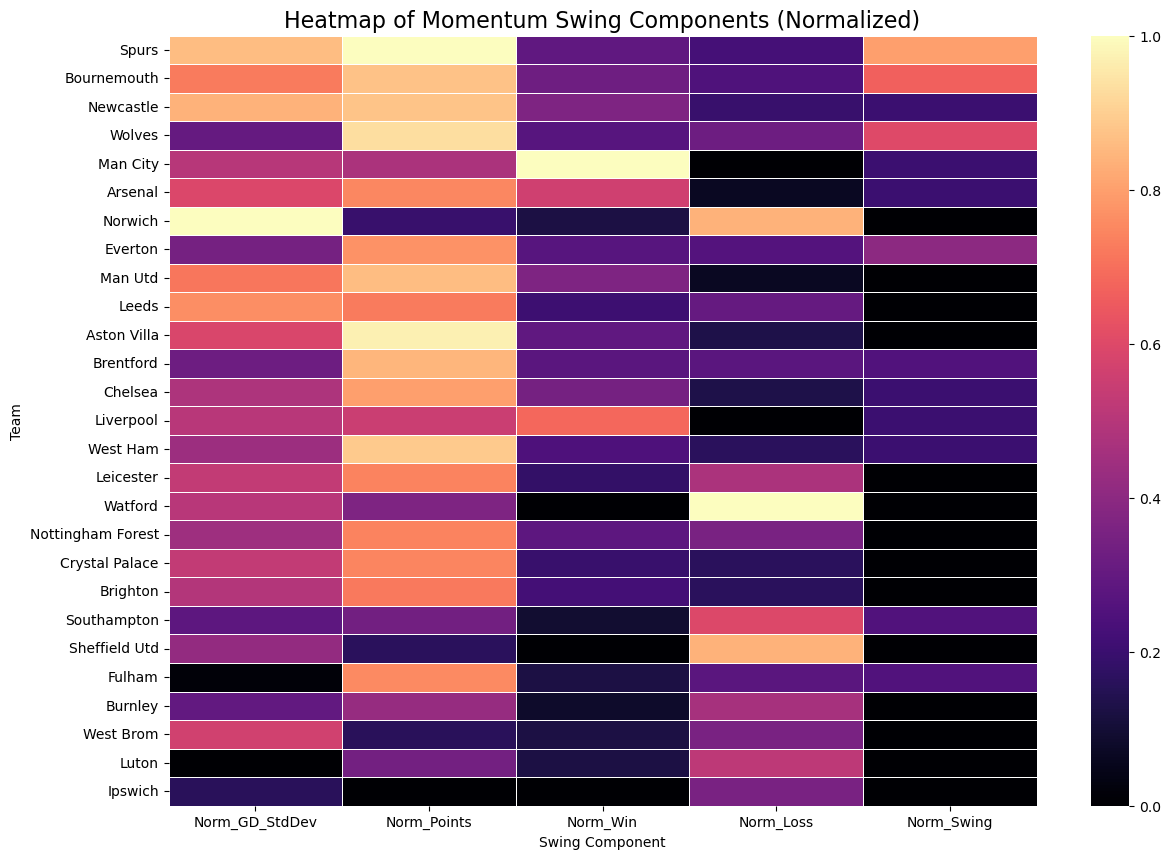

In [244]:
heatmap_data = team_swing_ranking[["Norm_GD_StdDev", "Norm_Points", "Norm_Win", "Norm_Loss", "Norm_Swing"]]

plt.figure(figsize=(14,10))
sns.heatmap(heatmap_data,cmap="magma",linewidths=0.5, annot=False)
plt.title("Heatmap of Momentum Swing Components (Normalized)", fontsize=16)
plt.xlabel("Swing Component")
plt.ylabel("Team")
plt.show()

In [250]:
big_swing_teams = team_season_swing_cases[team_season_swing_cases['HadBigLossAfterBigWin']]

big_swing_teams.sort_values(['HadBigLossAfterBigWin', 'MaxWinStreak', 'MaxLossStreak'], ascending=[False, False, False]).head(20)

Team     Season  MaxWinStreak  MaxLossStreak  HadBigWinStreak  \
99       Wolves  2024-2025             6              5             True   
11  Bournemouth  2023-2024             5              4             True   
52    Liverpool  2020-2021             5              4             True   
1       Arsenal  2021-2022             5              3             True   
62     Man City  2024-2025             4              4             True   
86        Spurs  2023-2024             4              4             True   
35      Everton  2020-2021             4              3             True   
38      Everton  2023-2024             4              3             True   
83        Spurs  2020-2021             4              3             True   
84        Spurs  2021-2022             4              3             True   
15    Brentford  2023-2024             3              6             True   
27      Chelsea  2022-2023             3              6             True   
79  Southampton  2020-2021             3              6             True   
41       Fulham  2022-2023             3              5             True   
10  Bournemouth  2022-2023             3              4             True   
71    Newcastle  2023-2024             3              4             True   
87        Spurs  2024-2025             3              4             True   
96       Wolves  2021-2022             3              4             True   
93     West Ham  2023-2024             3              3             True   
98       Wolves  2023-2024             3              3             True   

    HadBigLossAfterBigWin  
99                   True  
11                   True  
52                   True  
1                    True  
62                   True  
86                   True  
35                   True  
38                   True  
83                   True  
84                   True  
15                   True  
27                   True  
79                   True  
41                   True  
10                   True  
71                   True  
87                   True  
96                   True  
93                   True  
98                   True

# Q12. How frequent are hot streaks (winning/unbeaten streaks) and cold streaks (losing streaks)?

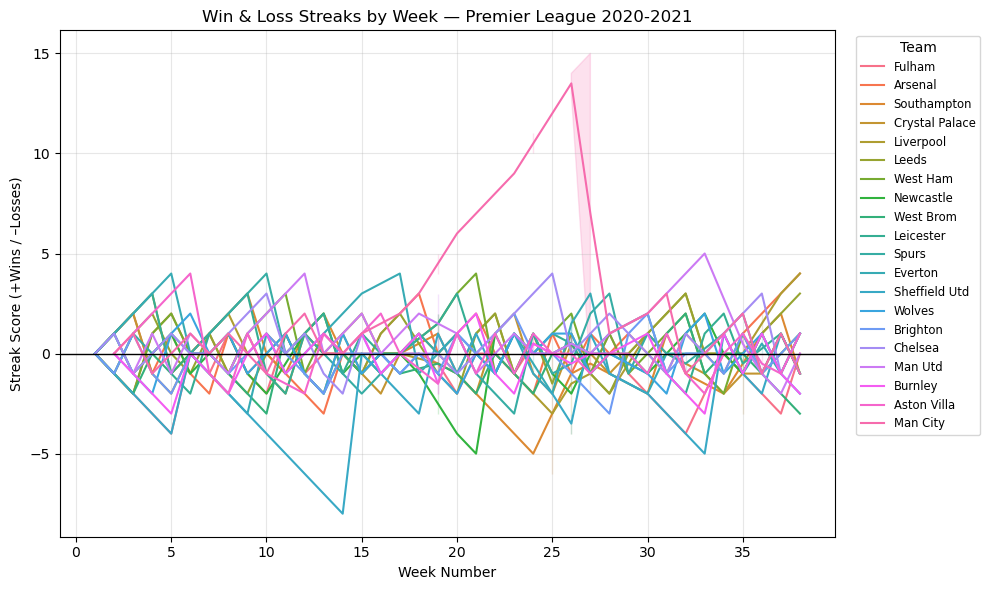

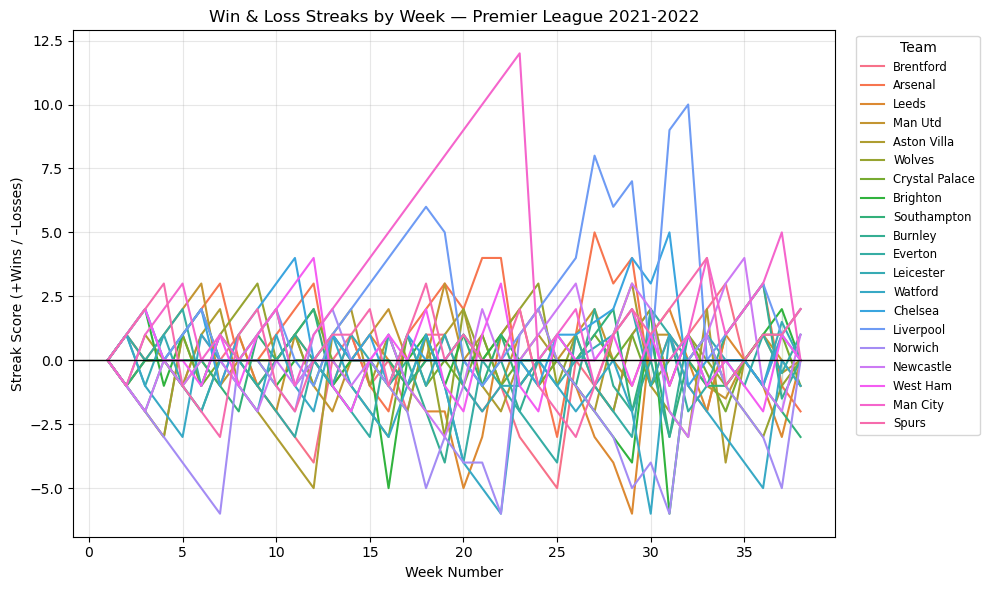

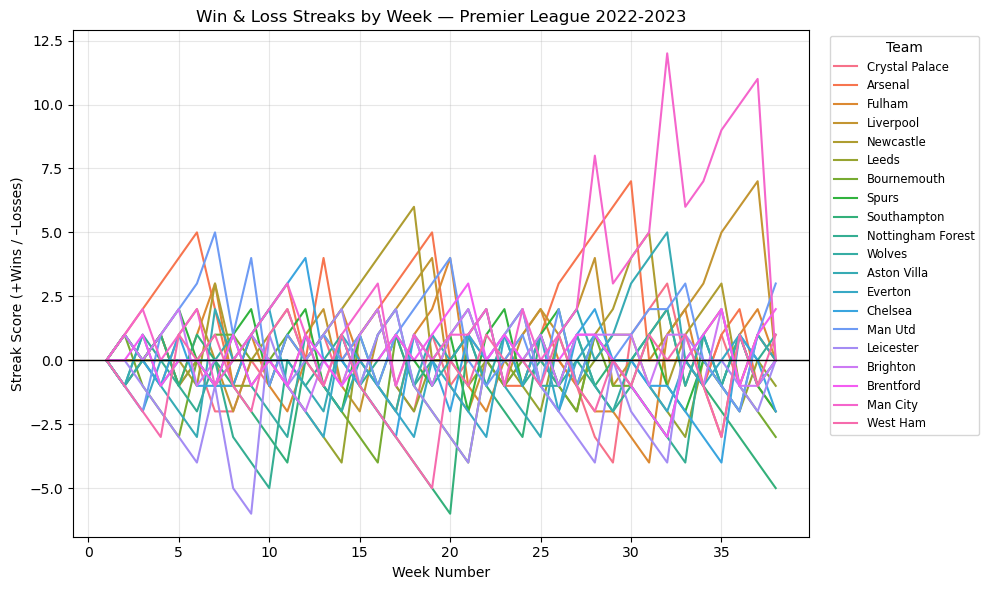

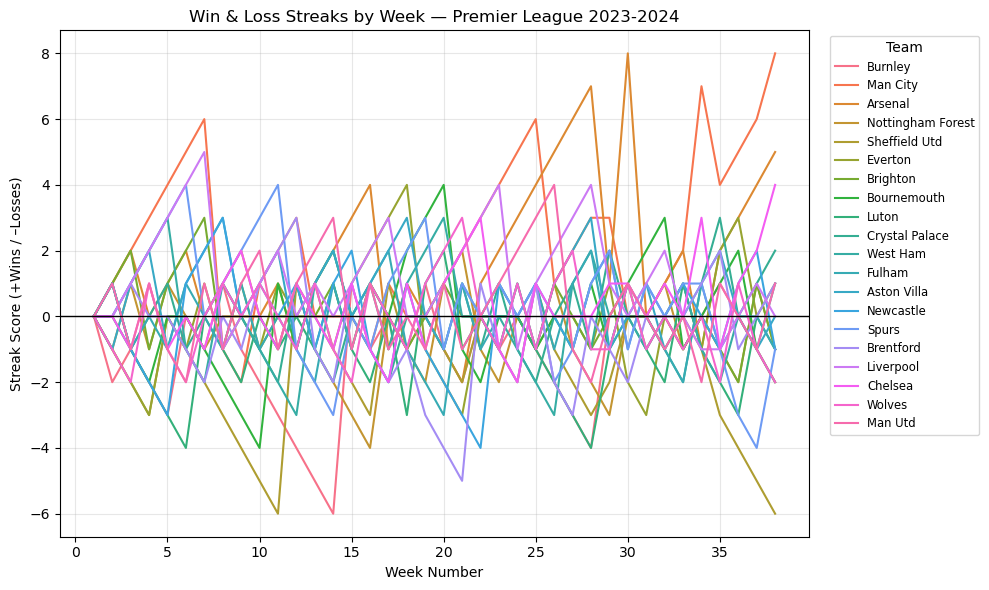

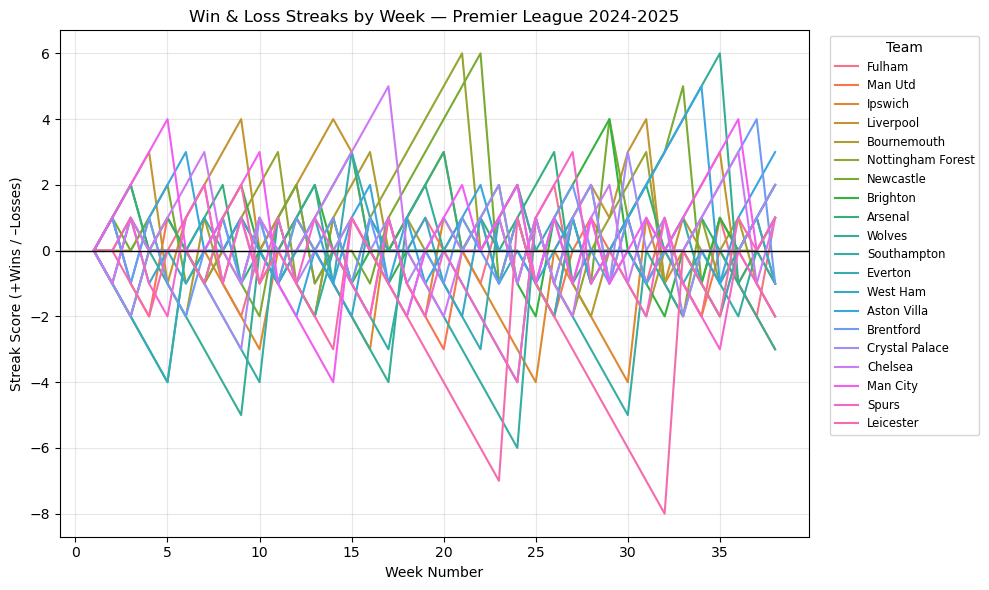

In [251]:
df['StreakScore'] = df['WinStreakBefore'] - df['LossStreakBefore']

seasons = sorted(df['Season'].unique())

for season in seasons:
    season_df = df[df['Season'] == season]

    plt.figure(figsize=(10,6))
    sns.lineplot(data=season_df, x='WeekNumber', y='StreakScore',hue='Team')

    plt.axhline(0, color='black', linewidth=1)  # 0 line = no streak
    plt.title(f"Win & Loss Streaks by Week — Premier League {season}")
    plt.xlabel("Week Number")
    plt.ylabel("Streak Score (+Wins / –Losses)")
    plt.grid(alpha=0.3)
    plt.legend(title="Team", bbox_to_anchor=(1.02, 1), loc='upper left', fontsize='small')
    plt.tight_layout()
    plt.show()

In [252]:
rows = []

for (team, season), group in df.groupby(['Team', 'Season']):
    group = group.sort_values('WeekNumber')
    
    results = group['Result'].values
    weeks   = group['WeekNumber'].values
    
    curr_win = 0
    curr_loss = 0
    win_start_week = None
    loss_start_week = None

    for i, r in enumerate(results):
        week = weeks[i]

        if r == 'W':
            # End a loss streak if it was active
            if curr_loss > 0:
                rows.append({'Team': team,'Season': season,'Type': 'Loss','Length': curr_loss,'StartWeek': loss_start_week,'EndWeek': weeks[i-1]})
                curr_loss = 0
                loss_start_week = None

            # Continue or start a win streak
            if curr_win == 0:
                win_start_week = week
            curr_win += 1

        elif r == 'L':
            # End a win streak if it was active
            if curr_win > 0:
                rows.append({'Team': team,'Season': season,'Type': 'Win','Length': curr_win,'StartWeek': win_start_week,'EndWeek': weeks[i-1]})
                curr_win = 0
                win_start_week = None

            # Continue or start a loss streak
            if curr_loss == 0:
                loss_start_week = week
            curr_loss += 1

        else:   # Ties
            if curr_win > 0:
                rows.append({'Team': team,'Season': season,'Type': 'Win','Length': curr_win,'StartWeek': win_start_week,'EndWeek': weeks[i-1]})
                curr_win = 0
                win_start_week = None

            if curr_loss > 0:
                rows.append({'Team': team,'Season': season,'Type': 'Loss','Length': curr_loss,'StartWeek': loss_start_week,'EndWeek': weeks[i-1]})
                curr_loss = 0
                loss_start_week = None

    # End any streak still going at the end of the season
    if curr_win > 0:
        rows.append({'Team': team,'Season': season,'Type': 'Win','Length': curr_win,'StartWeek': win_start_week,'EndWeek': weeks[-1]})
    if curr_loss > 0:
        rows.append({'Team': team,'Season': season,'Type': 'Loss','Length': curr_loss,'StartWeek': loss_start_week,'EndWeek': weeks[-1]})

streak_df = pd.DataFrame(rows)

In [253]:
HOT_thold = 3
COLD_thold = 3

hot_streaks = streak_df[(streak_df['Type'] == 'Win') & (streak_df['Length'] >= HOT_thold)]
cold_streaks = streak_df[(streak_df['Type'] == 'Loss') & (streak_df['Length'] >= COLD_thold)]

In [254]:
hot_count = len(hot_streaks)
cold_count = len(cold_streaks)

print("Total hot streaks (wins ≥ 3):", hot_count)
print("Total cold streaks (losses ≥ 3):", cold_count)

Total hot streaks (wins ≥ 3): 144
Total cold streaks (losses ≥ 3): 140


In [255]:
streaks_per_team_season = (streak_df[streak_df['Length'] >= 3].groupby(['Team','Season','Type']).size().reset_index(name='NumStreaks'))

avg_streaks_per_type = (streaks_per_team_season.groupby('Type')['NumStreaks'].mean())

avg_streaks_per_type

Type
Loss    2.333333
Win     2.215385
Name: NumStreaks, dtype: float64

In [256]:
def streak_groups(x):
    if x >= 7:
        return "7+"
    else:
        return str(x)

big_streaks = streak_df[streak_df['Length'] >= 3].copy()
big_streaks['Streak Length'] = big_streaks['Length'].apply(streak_groups)

streak_counts = (big_streaks.groupby(['Type','Streak Length']).size().reset_index(name='Count'))

streak_counts

Type Streak Length  Count
0  Loss             3     70
1  Loss             4     39
2  Loss             5     14
3  Loss             6     10
4  Loss            7+      7
5   Win             3     77
6   Win             4     36
7   Win             5     15
8   Win             6      8
9   Win            7+      8

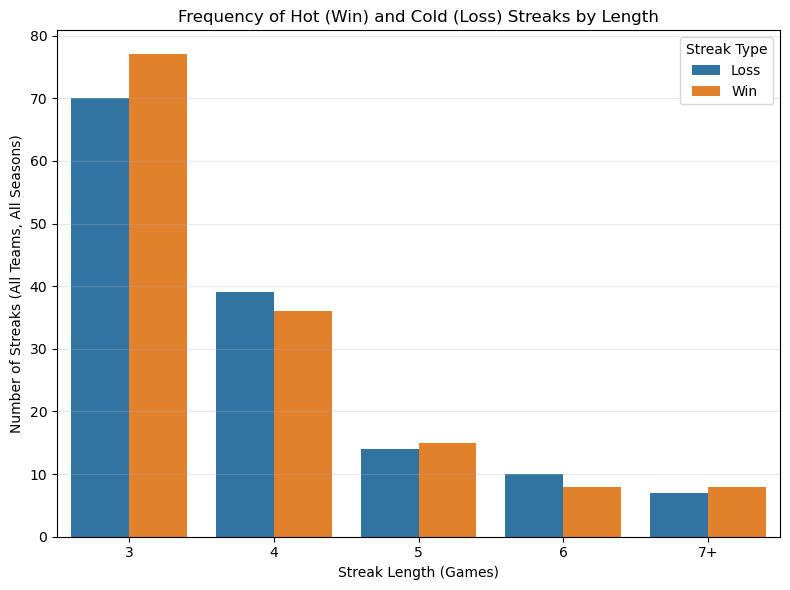

In [257]:
plt.figure(figsize=(8,6))
sns.barplot(data=streak_counts,x='Streak Length',y='Count',hue='Type')
plt.title("Frequency of Hot (Win) and Cold (Loss) Streaks by Length")
plt.xlabel("Streak Length (Games)")
plt.ylabel("Number of Streaks (All Teams, All Seasons)")
plt.grid(axis='y', alpha=0.3)
plt.legend(title="Streak Type")
plt.tight_layout()
plt.show()

We define a hot streak as a win streak of at least three matches and a cold streak as a losing streak of at least three matches. Using our streak_df table, which records every win and loss streak for every team and season, we computed the total number of hot and cold streaks, the average number of such streaks per team-season, and the distribution of streak lengths.

The bar chart shows how frequently different streak lengths occur across all five seasons. We see that 3-game win streaks are the most common type of hot streak, while longer streaks (5+ games) are much rarer. The same pattern holds for losing streaks, although cold streaks of length 3 appear slightly [more/less] frequent than equivalent hot streaks (depending on your actual results). Overall, this analysis quantifies how often teams get “hot” or “cold” over the course of a Premier League season.

# Conclusion:

In conclusion, we found that there is a strong correlation between momentum and match results. Specifically, there are much stronger correlations with momentum and win % or loss % than tie %. The best momentum metric to predict the match outcome is Points Earned in the last 3 matches. Points earned in the last 3 matches had the strongest correlation with win % and loss %. Overall, positive momentum metrics had stronger correlations with match results than negative momentum metrics. Although, loss streak had the strongest correlation with tie %. We also found that momentum plays a larger affect on small teams (non "big 6") than big ("big 6") teams. We also found that whether a team is home or away does not change the affect of momentum.